## Steps:

- set-up the cluster to be able to run jobs
- data preprocessing, saving data in more accessible format e.g.: pickle
- building data loader with transformations
- setting up the training
- collecting training history

### Cluster

Handy way to create virtual environment saving system packages and using different version of python

\>>> virtualenv --python=python3 --system-site-packages env-unet


### Evaluation of the predictions

Before the script metrics_acdc.py can be run data have to be prepared in a proper format, use notebook called: Evaluate Results to get predictions and save everything in the recquired format.

\>>> python metrics_acdc.py submission/gt  submission/gt/

### Communicating results

- network diagram: https://github.com/HarisIqbal88/PlotNeuralNet

### Parameters to tune

- normalization of layers (batchnorm? others?)
- activation functions (ReLu, LeakyRelu, others)
- transformations (which one and how many of them)
- loss function
- optimizer
- dropout
- learning rate decay
- number of filters

From Baumgartner:
- choice of loss function had significant role
- batchnormalization improved
- postprocessing to account for resampling error helped deal with one source of the error
"Moreover, we found that resampling of the predictions to the original image resolution was a
significant source of errors. This could be reduced by resampling the softmax
output with linear interpolation, rather than the predicted masks."


For each training report:
major changes, loss fcn plot, dice scores for LVC, RVC, MYO

In [1]:
import pandas as pd
import matplotlib.pyplot as plt
import numpy as np
import warnings
warnings.filterwarnings('ignore')

def report_values(df, name, all_=False):
    avg = df['Dice '+name].mean()
    med = df['Dice '+name].median()
    print("Dice {}: mean: {:.3}, median: {:.3}".format(name,avg,med))     
    
    if all_:
        cols = []
        for col in df.columns:
            if "Dice" in col:
                cols.extend(df[col].values.tolist())
        print(np.mean(cols))
    return df['Dice '+name].values

def calculate_results(fname, loss=True):
    df = pd.read_csv(fname)
    df['Types'] = [x.split('_')[1] for x in df['Name'].values]
    for x in df.columns[1:-1]:
        if 'Dice' in x:
            vals = df.groupby('Types')[x].describe()['mean'].values
            print("{:8} => ED: {:<6.4}%, ES: {:6.4}%".format(x, vals[0]*100, vals[1]*100))
    if loss:
        train_history = pd.read_csv("results-experiment/history/train_history_"+"_".join(fname.split('_')[1:-2])+".csv")
        val_history = pd.read_csv("results-experiment/history/val_history_"+"_".join(fname.split('_')[1:-2])+".csv")    
        print("Minimum loss: train: {:.6} val:{:.6}".format(min(train_history.values)[0], min(val_history.values)[0]))
        print("Mean loss: train: {:.6} val:{:.6}".format(np.mean(train_history.values), np.mean(val_history.values)))

    report_values(df, "LV")
    report_values(df, "RV")    
    report_values(df, "MYO")
    x = np.concatenate((df['Dice MYO'].values, df['Dice RV'].values, df['Dice LV'].values))
    overallavg = np.mean(x)
    overallmed = np.median(x)
    print("Overall dice: mean: {:.3}, median: {:.3}".format(overallavg, overallmed)) 
    
    if loss:
        plt.figure(figsize=(18,8))
        plt.rcParams.update({'font.size': 25})
        plt.plot(train_history, linewidth=5, label='train')
        plt.plot(val_history, linewidth=5, label='val')
        plt.legend()
        plt.xlabel("epoch")
        plt.ylabel("loss")
        plt.box('off')
        plt.grid('on')
        plt.show()

In [2]:
def plot_boxplots(df):
    df['Types'] = [x.split('_')[2] for x in df['Name'].values]
    vals = []
    titles = []
    for x in df.columns[1:-1]:
        if 'Dice' in x:
            vals_d = df[df['Types'] == 'ED'][[x]]
            vals_s = df[df['Types'] == 'ES'][[x]]      
            vals.append(vals_d)
            vals.append(vals_s)        
            titles.append(x+' -> ED')
            titles.append(x+' -> ES')
    plt.figure(figsize=(30,20))
    #dat = df[df['Types'] == 'ED'][['Dice LV']]
    for i, dat in enumerate(vals):
        plt.subplot(2,3,i+1)
        bpdict = dat.boxplot(whis=[5, 95], return_type='dict')
        median = np.median(dat.values)
        mean = np.mean(dat.values)
        annotate_boxplot(bpdict, median, mean, x_loc=0)
        plt.plot(np.average(bpdict['medians'][0].get_xdata()), np.average(dat),
                     color='w', marker='*', markersize=20, markeredgecolor='k')
        plt.title(titles[i])
        plt.box("off")
    plt.show() 

In [3]:
def annotate_boxplot(bpdict, median, mean, annotate_params=None,
                     x_offset=0.05, x_loc=0,
                     text_offset_x=35,
                     text_offset_y=5):
    """Annotates a matplotlib boxplot with labels marking various centile levels.

    Parameters:
    - bpdict: The dict returned from the matplotlib `boxplot` function. If you're using pandas you can
    get this dict by setting `return_type='dict'` when calling `df.boxplot()`.
    - annotate_params: Extra parameters for the plt.annotate function. The default setting uses standard arrows
    and offsets the text based on other parameters passed to the function
    - x_offset: The offset from the centre of the boxplot to place the heads of the arrows, in x axis
    units (normally just 0-n for n boxplots). Values between around -0.15 and 0.15 seem to work well
    - x_loc: The x axis location of the boxplot to annotate. Usually just the number of the boxplot, counting
    from the left and starting at zero.
    text_offset_x: The x offset from the arrow head location to place the associated text, in 'figure points' units
    text_offset_y: The y offset from the arrow head location to place the associated text, in 'figure points' units
    """
    if annotate_params is None:
        annotate_params = dict(xytext=(text_offset_x, text_offset_y), textcoords='offset points', arrowprops={'arrowstyle':'->'})
    
    plt.annotate('Median: {:.4}'.format(median, mean), (x_loc + 1 + x_offset, bpdict['medians'][x_loc].get_ydata()[0]), **annotate_params)
    plt.annotate('Mean: {:.4}'.format(mean), (x_loc + 1 + x_offset, mean), **annotate_params)

    #plt.plot(np.average(bpdict['medians'][0].get_xdata()), np.average(df[df['Types'] == 'ED'][['Dice LV']]),
    #         color='w', marker='*', markersize=20, markeredgecolor='k')

#     plt.annotate('25%', (x_loc + 1 + x_offset, bpdict['boxes'][x_loc].get_ydata()[0]), **annotate_params)
#     plt.annotate('75%', (x_loc + 1 + x_offset, bpdict['boxes'][x_loc].get_ydata()[2]), **annotate_params)
#     plt.annotate('5%', (x_loc + 1 + x_offset, bpdict['caps'][x_loc*2].get_ydata()[0]), **annotate_params)
#     plt.annotate('95%', (x_loc + 1 + x_offset, bpdict['caps'][(x_loc*2)+1].get_ydata()[0]), **annotate_params)

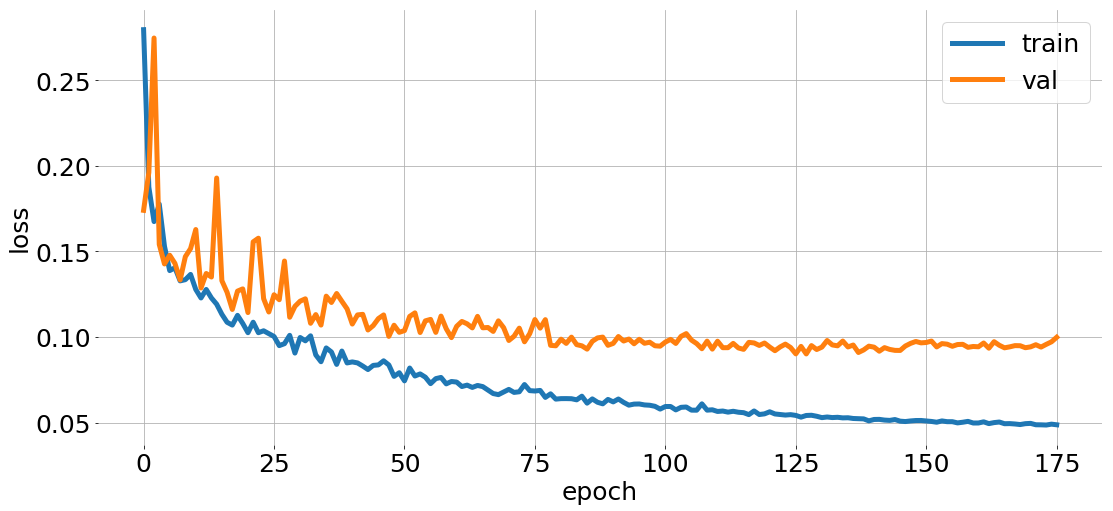

In [398]:
def plot_history(history, phase):
    plt.plot(history, linewidth=5, label=phase)
    plt.xlabel("epoch")
    plt.ylabel("loss")
    
train_history = pd.read_csv('./temp/intermed_train_history.csv')
val_history = pd.read_csv('./temp/intermed_val_history.csv')

plt.figure(figsize=(18,8))
plt.rcParams.update({'font.size': 25})
plot_history(train_history, 'train')
plot_history(val_history, 'val')
plt.grid("on")
plt.legend()
plt.box('off')
plt.show()

### 1st training

major changes:
- starting number of filters => 32
- no transformations
- no cross validation
- no normalization for layers in u-net (batch normalization)
- no dropout (originally in Isensee 0.3)
- 300 epochs
- loss function (0.5 * dice + 0.5 binary cross entropy) -> not as  Baumgartner: cross entropy loss or Isensee: multi-class dice loss

Dice LV  => ED: 5.507 %, ES:  42.61%
Dice RV  => ED: 0.2974%, ES:  13.68%
Dice MYO => ED: 9.338 %, ES:  52.31%
Minimum loss: train: 0.0104384 val:0.0837305
Mean loss: train: 0.0419517 val:0.112108
Dice LV: mean: 0.241, median: 0.0
Dice RV: mean: 0.0699, median: 0.0
Dice MYO: mean: 0.308, median: 0.0921
Overall dice: mean: 0.206, median: 0.0


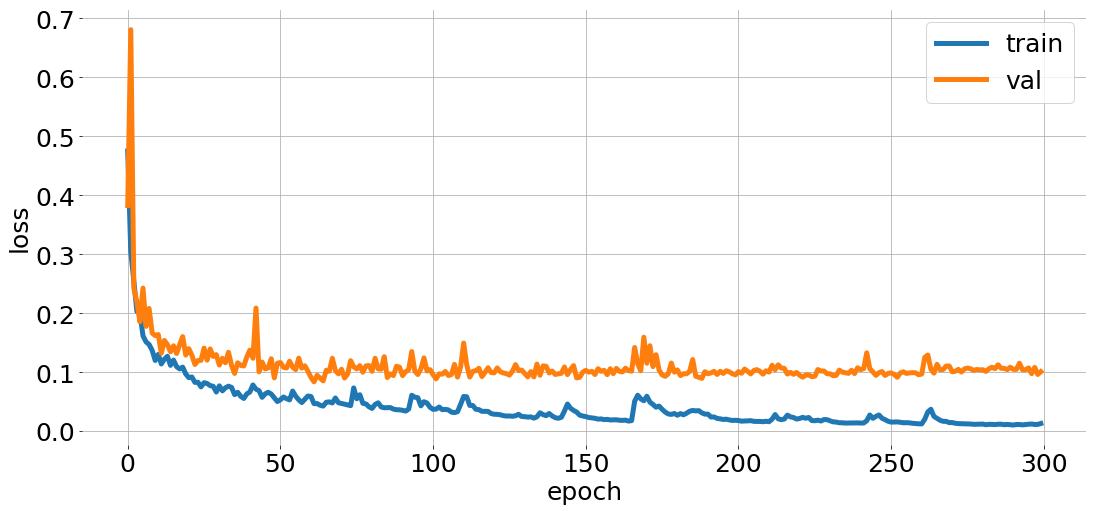

In [4]:
fname = 'results-experiment/results/results_1_train_simple_20200118_134622.csv'
calculate_results(fname)

### 2nd training

major changes:

- starting with 48 number of filters
- added transformations: mirror, random transformation from the following: spatial transform with elastic   transform, rotation and scale or random crop transform (Isenseee code and paper)
-


Dice LV  => ED: 4.426 %, ES:  27.73%
Dice RV  => ED: 0.2347%, ES:  11.57%
Dice MYO => ED: 8.271 %, ES:  35.38%
Minimum loss: train: 0.0527029 val:0.0665173
Mean loss: train: 0.0845989 val:0.0998755
Dice LV: mean: 0.161, median: 0.0
Dice RV: mean: 0.059, median: 0.0
Dice MYO: mean: 0.218, median: 0.108
Overall dice: mean: 0.146, median: 0.0


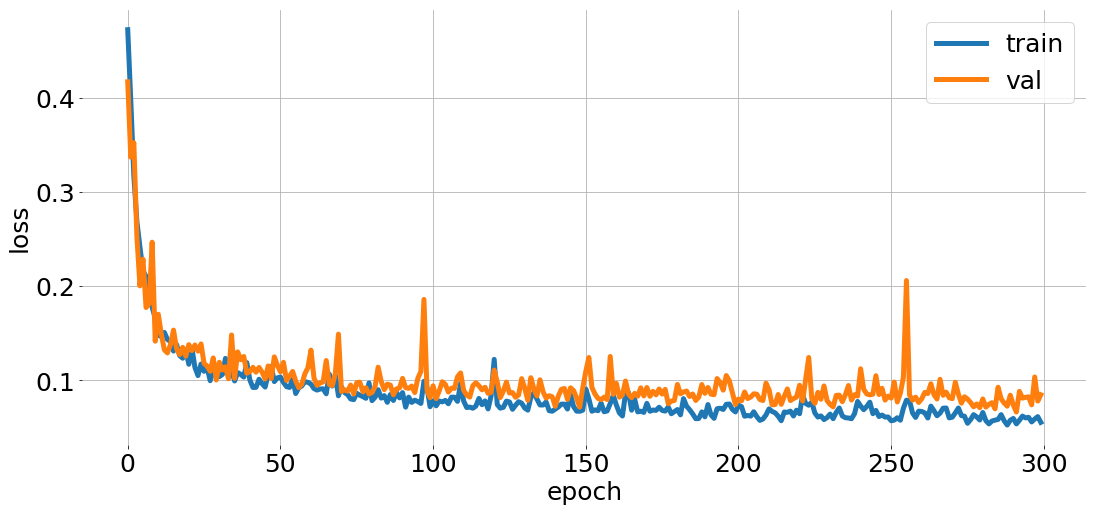

In [29]:
fname = 'results-experiment/results/results_2_train_transforms_48_filters_20200119_032922.csv'
calculate_results(fname)

### 3rd training

major changes:

- batch norm

Dice LV  => ED: 3.607 %, ES:  27.07%
Dice RV  => ED: 0.3858%, ES:  11.43%
Dice MYO => ED: 8.469 %, ES:  34.91%
Minimum loss: train: 0.0450127 val:0.059111
Mean loss: train: 0.0712831 val:0.0876358
Dice LV: mean: 0.153, median: 0.0
Dice RV: mean: 0.0591, median: 0.0
Dice MYO: mean: 0.217, median: 0.0959
Overall dice: mean: 0.143, median: 0.0


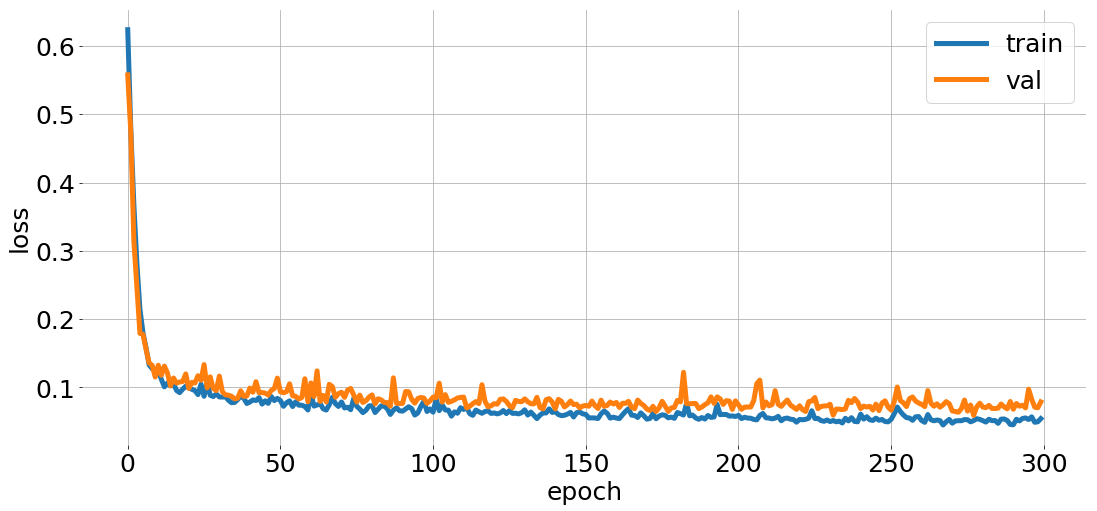

In [30]:
fname = 'results-experiment/results/results_3_batchnorm_20200119_194642.csv'
calculate_results(fname)

### 4th training

major changes:

- going back to 32 initial filters (as increasing number of fileters didn't help)
- batchnorm (leaving as it was previously)
- transformations (leaving as it was previously)

Dice LV  => ED: 4.197 %, ES:  27.84%
Dice RV  => ED: 0.7646%, ES:  11.55%
Dice MYO => ED: 8.675 %, ES:  36.27%
Minimum loss: train: 0.0475974 val:0.0603675
Mean loss: train: 0.0751875 val:0.0894118
Dice LV: mean: 0.16, median: 0.0
Dice RV: mean: 0.0616, median: 0.0
Dice MYO: mean: 0.225, median: 0.117
Overall dice: mean: 0.149, median: 0.0


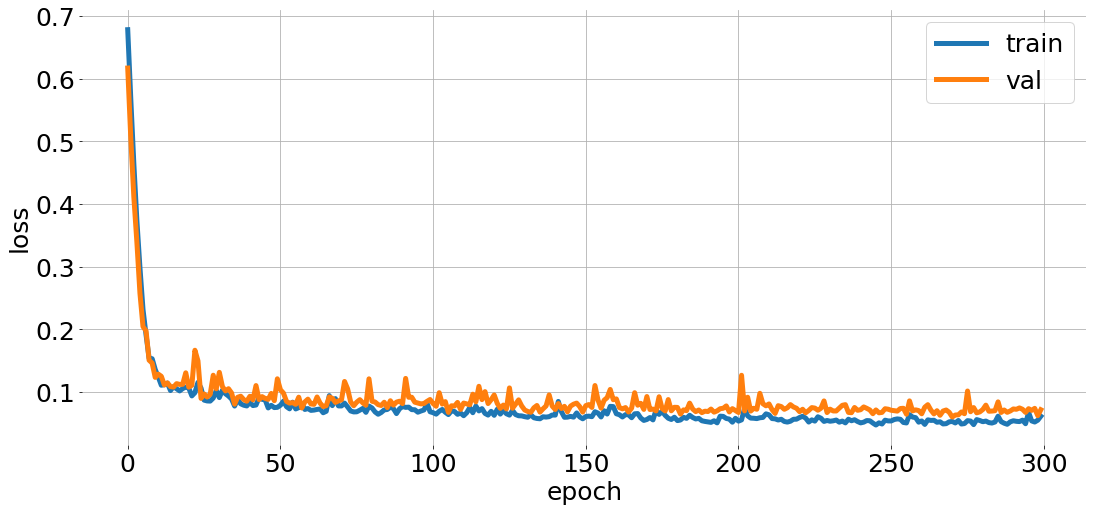

In [31]:
fname = 'results-experiment/results/results_4_32f_batchnorm_20200120_000330.csv'
calculate_results(fname)

### 5th training

major changes:

- dice loss function (bce_weight=0)
- no transformations

Dice LV  => ED: 71.37 %, ES:  46.39%
Dice RV  => ED: 37.05 %, ES:  18.75%
Dice MYO => ED: 66.89 %, ES:  56.93%
Minimum loss: train: 0.059137 val:0.106911
Mean loss: train: 0.107018 val:0.146235
Dice LV: mean: 0.589, median: 0.87
Dice RV: mean: 0.279, median: 0.0
Dice MYO: mean: 0.619, median: 0.857
Overall dice: mean: 0.496, median: 0.777


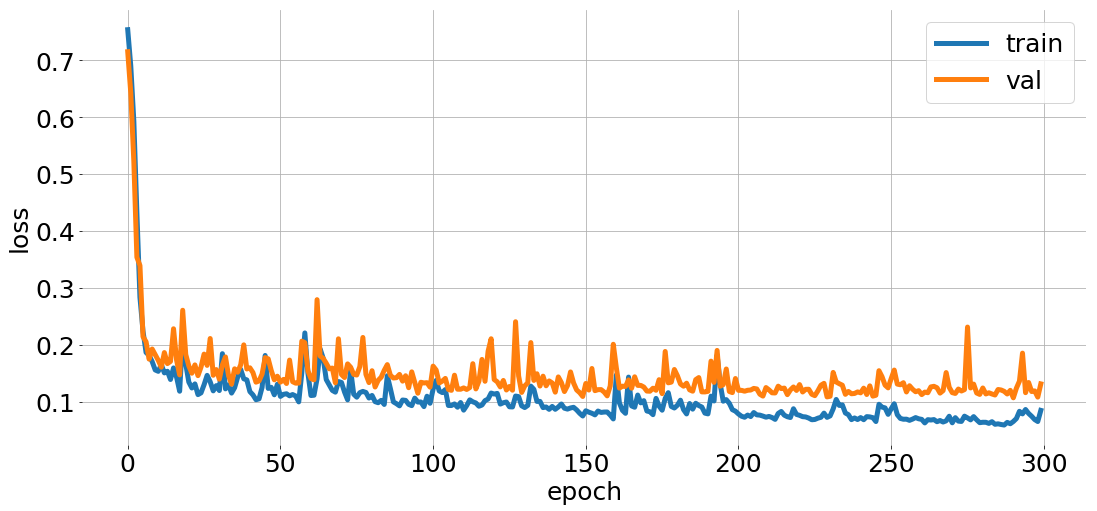

In [32]:
fname = 'results-experiment/results/results_5_train_no_transforms_20200120_023905.csv'
calculate_results(fname)

### 6th training

major changes:

- dice loss (bce_weight=0)
- transformations

Dice LV  => ED: 65.32 %, ES:  41.34%
Dice RV  => ED: 29.28 %, ES:  14.93%
Dice MYO => ED: 60.99 %, ES:  52.07%
Minimum loss: train: 0.098731 val:0.110166
Mean loss: train: 0.143141 val:0.158169
Dice LV: mean: 0.533, median: 0.791
Dice RV: mean: 0.221, median: 0.0
Dice MYO: mean: 0.565, median: 0.792
Overall dice: mean: 0.44, median: 0.611


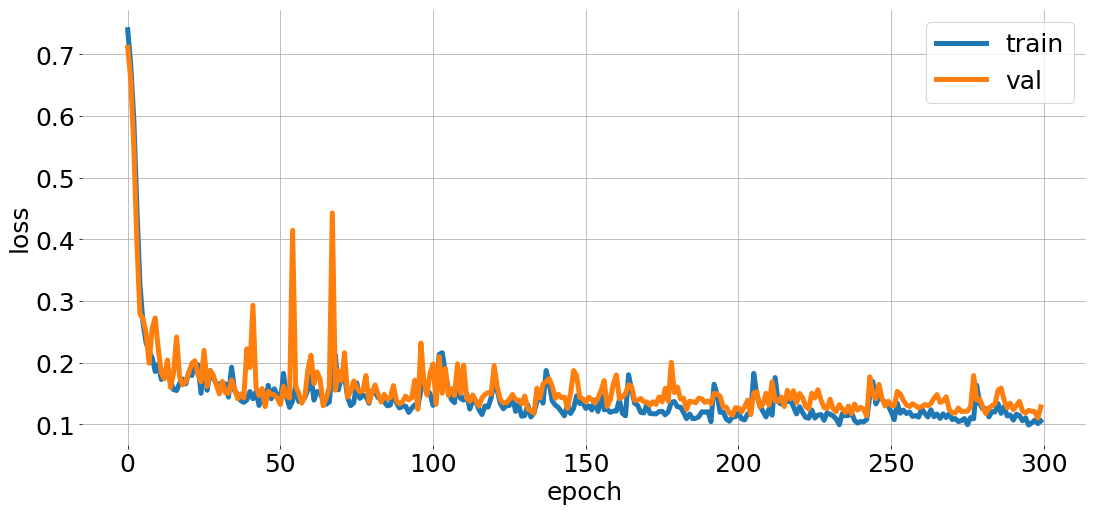

In [33]:
fname = 'results-experiment/results/results_6_20200122_085511.csv'
calculate_results(fname)

### 7th training

major changes:
- no transforms
- lr decay every step

Dice LV  => ED: 76.69 %, ES:  48.55%
Dice RV  => ED: 38.82 %, ES:  19.03%
Dice MYO => ED: 73.28 %, ES:  60.04%
Minimum loss: train: 0.046829 val:0.0988246
Mean loss: train: 0.0829216 val:0.126917
Dice LV: mean: 0.626, median: 0.909
Dice RV: mean: 0.289, median: 0.0
Dice MYO: mean: 0.667, median: 0.873
Overall dice: mean: 0.527, median: 0.846


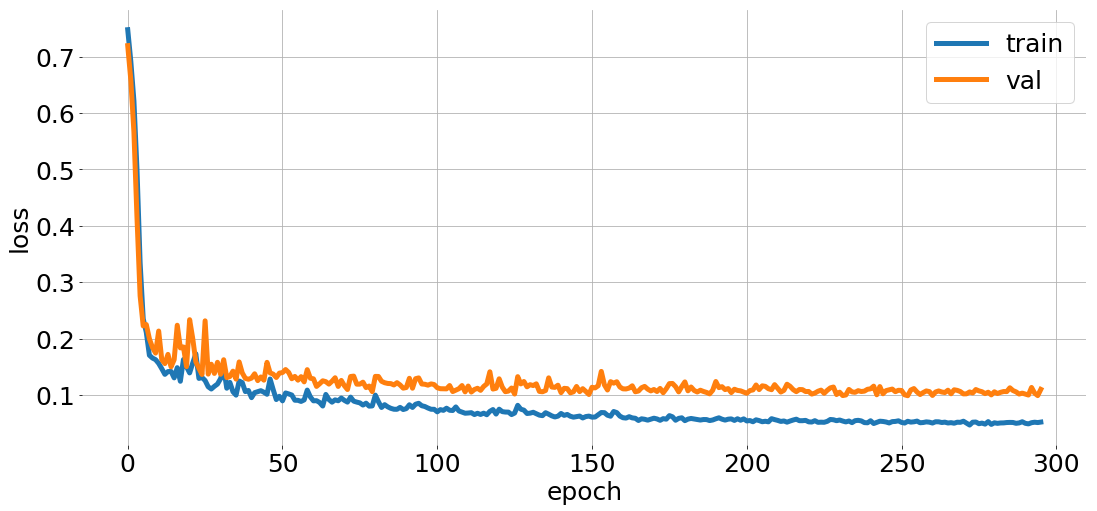

In [34]:
fname = 'results-experiment/results/results_7_20200122_162840.csv'
calculate_results(fname)

### 8th training

major changes:

- leaky relu with alpha 0.01

Dice LV  => ED: 77.71 %, ES:  47.77%
Dice RV  => ED: 38.0  %, ES:  19.44%
Dice MYO => ED: 73.77 %, ES:  58.02%
Minimum loss: train: 0.0471673 val:0.0924102
Mean loss: train: 0.0795645 val:0.12531
Dice LV: mean: 0.627, median: 0.912
Dice RV: mean: 0.287, median: 0.0
Dice MYO: mean: 0.659, median: 0.867
Overall dice: mean: 0.525, median: 0.838


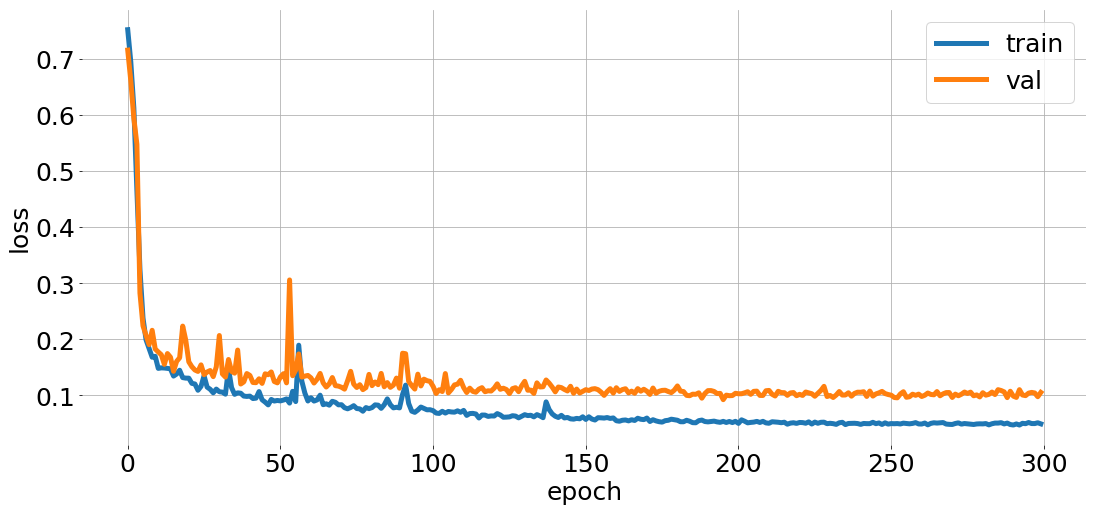

In [35]:
fname = 'results-experiment/results/results_8_leaky_relu_20200122_221921.csv'
calculate_results(fname)

### 9th training

major changes:
- more batches in one epoch - 200
- transformations
- batch size 4

Dice LV  => ED: 65.2  %, ES:  42.45%
Dice RV  => ED: 28.91 %, ES:  12.04%
Dice MYO => ED: 61.27 %, ES:  51.66%
Minimum loss: train: 0.0885986 val:0.109157
Mean loss: train: 0.127699 val:0.144959
Dice LV: mean: 0.538, median: 0.765
Dice RV: mean: 0.205, median: 0.0
Dice MYO: mean: 0.565, median: 0.798
Overall dice: mean: 0.436, median: 0.579


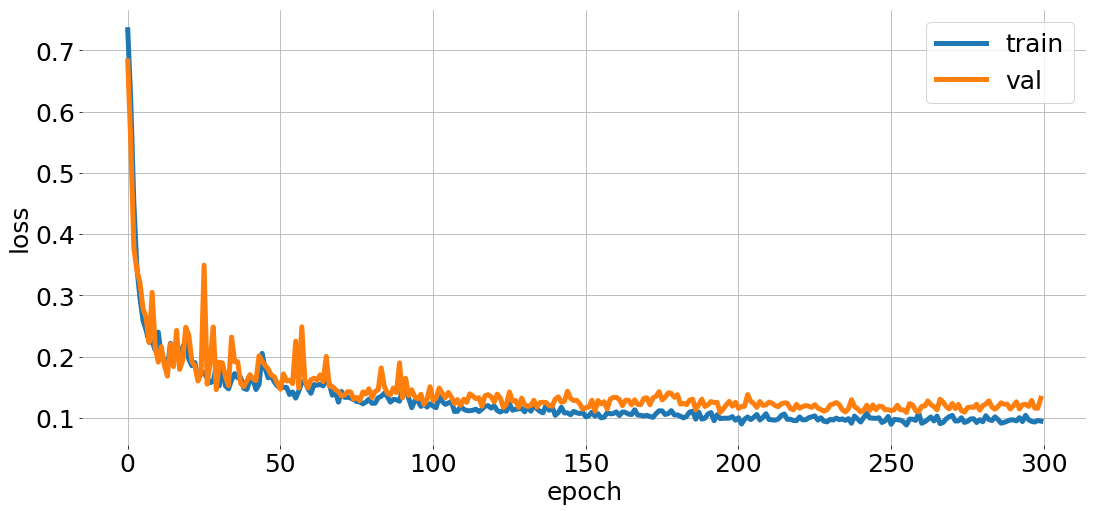

In [36]:
fname = 'results-experiment/results/results_9_20200212_230609.csv'
calculate_results(fname)

### 10th training

major changes:
- more batches in one epoch - 2000
- transformations
- batch size 4

In [3]:
fname = 'results_20200213_150855.csv'
calculate_results(fname, False)

Dice LV  => ED: 73.54 %, ES:  46.96%
Dice RV  => ED: 35.64 %, ES:   17.0%
Dice MYO => ED: 69.9  %, ES:  58.66%
Dice LV: mean: 0.603, median: 0.877
Dice RV: mean: 0.263, median: 0.0
Dice MYO: mean: 0.643, median: 0.856
Overall dice: mean: 0.503, median: 0.799


In [4]:
fname = 'results_20200213_101838.csv'
calculate_results(fname, False)

Dice LV  => ED: 73.56 %, ES:  47.91%
Dice RV  => ED: 37.66 %, ES:  17.67%
Dice MYO => ED: 70.39 %, ES:  59.29%
Dice LV: mean: 0.607, median: 0.867
Dice RV: mean: 0.277, median: 0.0
Dice MYO: mean: 0.648, median: 0.856
Overall dice: mean: 0.511, median: 0.816


In [12]:
df = pd.read_csv("results_20200213_150855.csv")
df

Name   Dice LV  Volume LV  Err LV(ml)   Dice RV  Volume RV  \
0      patient1_ED  0.969875      0.675      -0.011  0.794521      0.130   
1      patient1_ES  0.934884      0.420      -0.020  0.000000      0.000   
2      patient2_ED  0.925714      0.176       0.002  0.000000      0.000   
3      patient2_ES  0.881356      0.031       0.003  0.000000      0.000   
4      patient3_ED  0.924171      0.227       0.032  0.000000      0.000   
5      patient3_ES  0.902256      0.137       0.008  0.000000      0.000   
6      patient4_ED  0.944591      0.192       0.005  0.000000      0.000   
7      patient4_ES  0.916300      0.122       0.017  0.000000      0.000   
8      patient5_ED  0.952381      0.291      -0.006  0.459082      0.374   
9      patient5_ES  0.929630      0.273       0.006  0.000000      0.000   
10     patient6_ED  0.854305      0.321       0.038  0.721072      0.493   
11     patient6_ES  0.935943      0.288       0.014  0.000000      0.000   
12     patient7_ED  0.956822      0.569      -0.020  0.931880      0.566   
13     patient7_ES  0.961783      0.478       0.014  0.847085      0.468   
14     patient8_ED  0.892193      0.287       0.036  0.000000      0.000   
15     patient8_ES  0.752475      0.126       0.050  0.000000      0.000   
16     patient9_ED  0.953451      0.601      -0.044  0.000000      0.000   
17     patient9_ES  0.897436      0.355      -0.070  0.000000      0.000   
18    patient10_ED  0.914634      0.251       0.010  0.256716      0.061   
19    patient10_ES  0.000000      0.000      -0.115  0.000000      0.000   
20    patient11_ED  0.955348      0.493       0.023  0.898089      0.316   
21    patient11_ES  0.904215      0.355      -0.073  0.917073      0.203   
22    patient12_ED  0.978486      0.625      -0.005  0.000000      0.000   
23    patient12_ES  0.953101      0.330      -0.001  0.000000      0.000   
24    patient13_ED  0.909091      0.324      -0.012  0.000000      0.000   
25    patient13_ES  0.905405      0.071      -0.006  0.000000      0.000   
26    patient14_ED  0.972678      0.623      -0.035  0.000000      0.000   
27    patient14_ES  0.938239      0.372      -0.017  0.000000      0.000   
28    patient15_ED  0.927039      0.113      -0.007  0.000000      0.000   
29    patient15_ES  0.000000      0.000       0.000  0.000000      0.000   
..             ...       ...        ...         ...       ...        ...   
170   patient86_ED  0.000000      0.000       0.000  0.000000      0.000   
171   patient86_ES  0.000000      0.000       0.000  0.000000      0.000   
172   patient87_ED  0.906977      0.117      -0.024  0.927139      0.973   
173   patient87_ES  0.891304      0.087      -0.010  0.885246      0.469   
174   patient88_ED  0.774648      0.073       0.004  0.441718      0.039   
175   patient88_ES  0.000000      0.000       0.000  0.000000      0.000   
176   patient89_ED  0.935574      0.341      -0.032  0.842105      0.101   
177   patient89_ES  0.902256      0.070       0.007  0.866667      0.044   
178   patient90_ED  0.950131      0.195       0.009  0.896512      0.788   
179   patient90_ES  0.000000      0.000       0.000  0.000000      0.000   
180   patient91_ED  0.000000      0.000      -0.027  0.928571      0.407   
181   patient91_ES  0.000000      0.000       0.000  0.000000      0.000   
182   patient92_ED  0.000000      0.000       0.000  0.914798      0.310   
183   patient92_ES  0.000000      0.000       0.000  0.000000      0.000   
184   patient93_ED  0.000000      0.000       0.000  0.973061      0.617   
185   patient93_ES  0.000000      0.000       0.000  0.000000      0.000   
186   patient94_ED  0.897314      0.344       0.055  0.000000      0.000   
187   patient94_ES  0.833333      0.039       0.006  0.000000      0.000   
188   patient95_ED  0.950355      0.210      -0.003  0.939189      0.304   
189   patient95_ES  0.000000      0.000       0.000  0.000000      0.000   
190   patient96_ED  0.944700      0.214      -0.006  0.972358 

In [13]:
df.columns

Index(['Name', 'Dice LV', 'Volume LV', 'Err LV(ml)', 'Dice RV', 'Volume RV',
       'Err RV(ml)', 'Dice MYO', 'Volume MYO', 'Err MYO(ml)'],
      dtype='object')

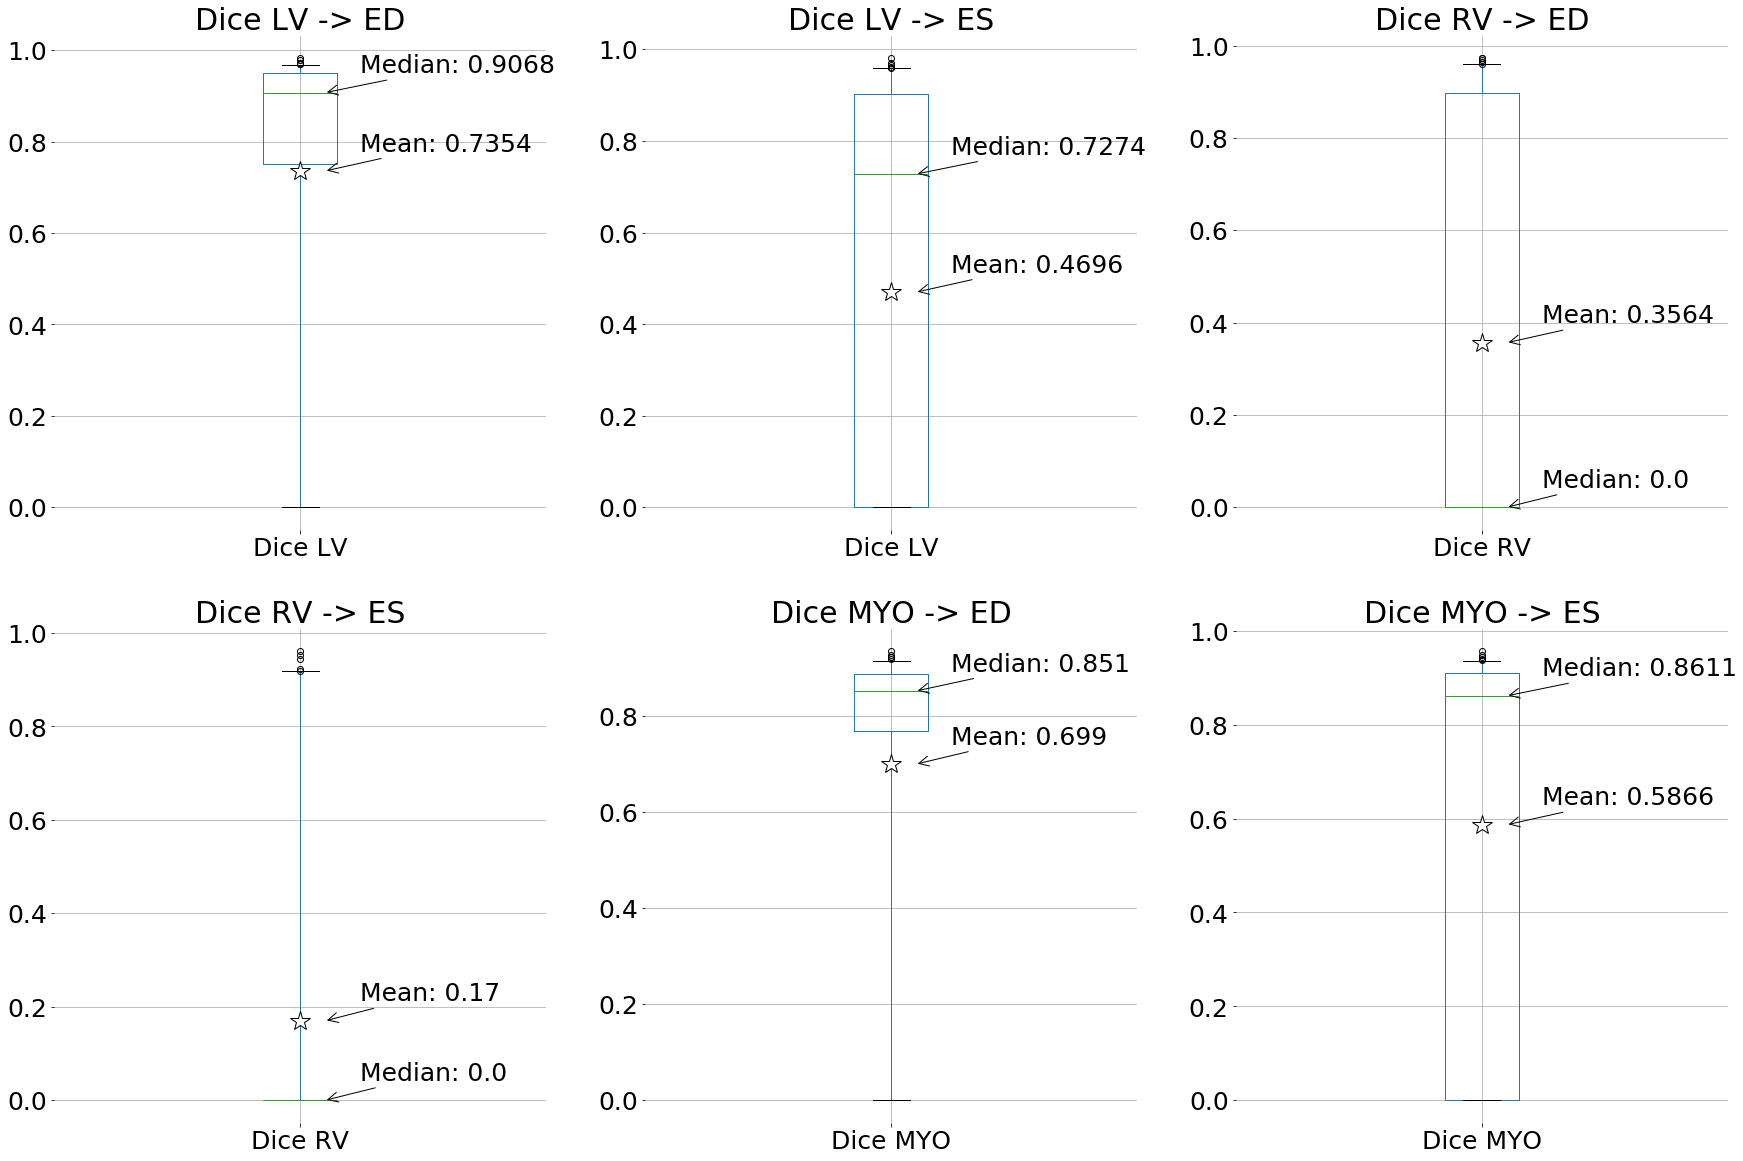

In [15]:
plot_boxplots(df)

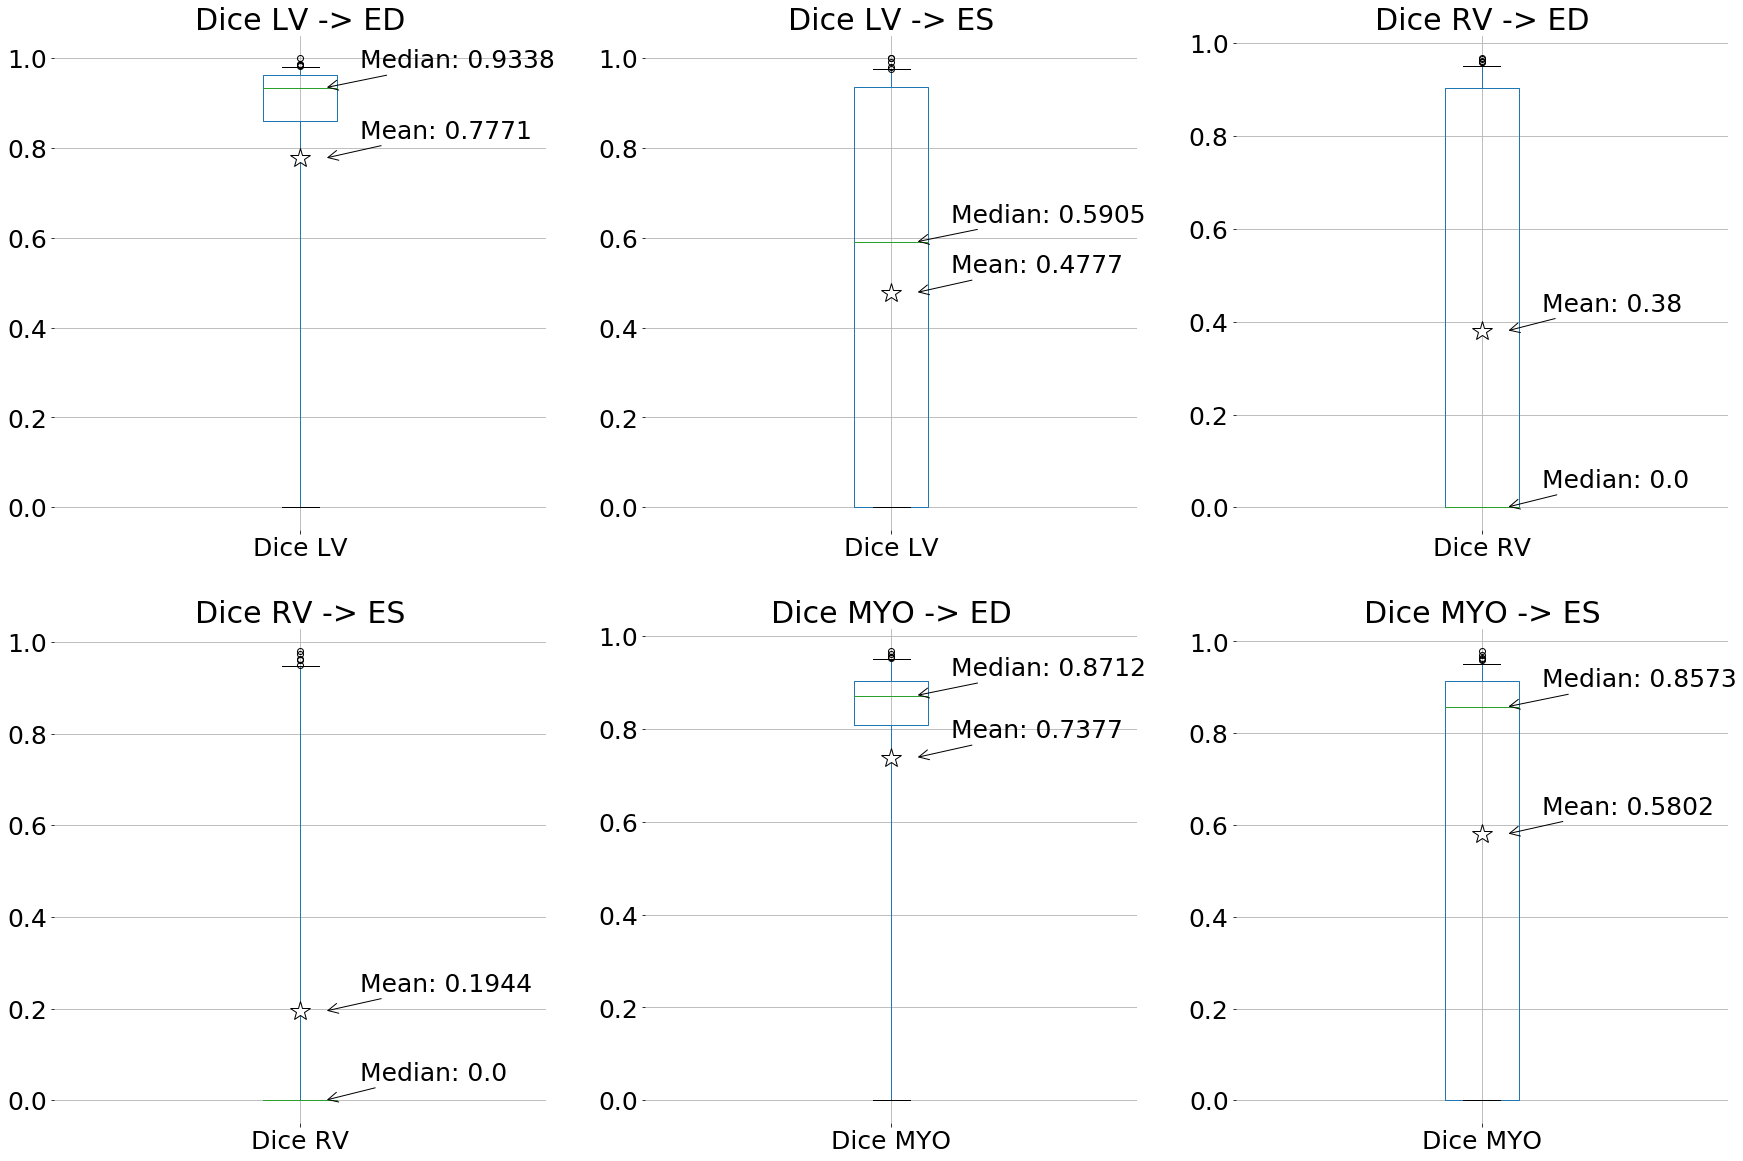

In [16]:
df = pd.read_csv('results-experiment/results/results_8_leaky_relu_20200122_221921.csv')
plot_boxplots(df)

In [17]:
patients = [int(x.split('_')[0].replace('patient','')) for x in df[df['Types'] == 'ED'][df['Dice LV'] <= 0.6]['Name']]

In [18]:
patients

[22, 23, 28, 30, 43, 47, 50, 61, 63, 64, 72, 85, 86, 87, 92, 93, 100]

In [148]:
from preprocessing import load_dataset

data = load_dataset()

In [149]:
data[22].keys()

dict_keys(['weight', 'ed_data', 'es_data', 'ed_gt', 'es_gt', 'pathology', 'height'])

In [161]:
missing_es = [x for x in data if data[x]["es_data"] == []]
missing_ed = [x for x in data if data[x]["ed_data"] == []]

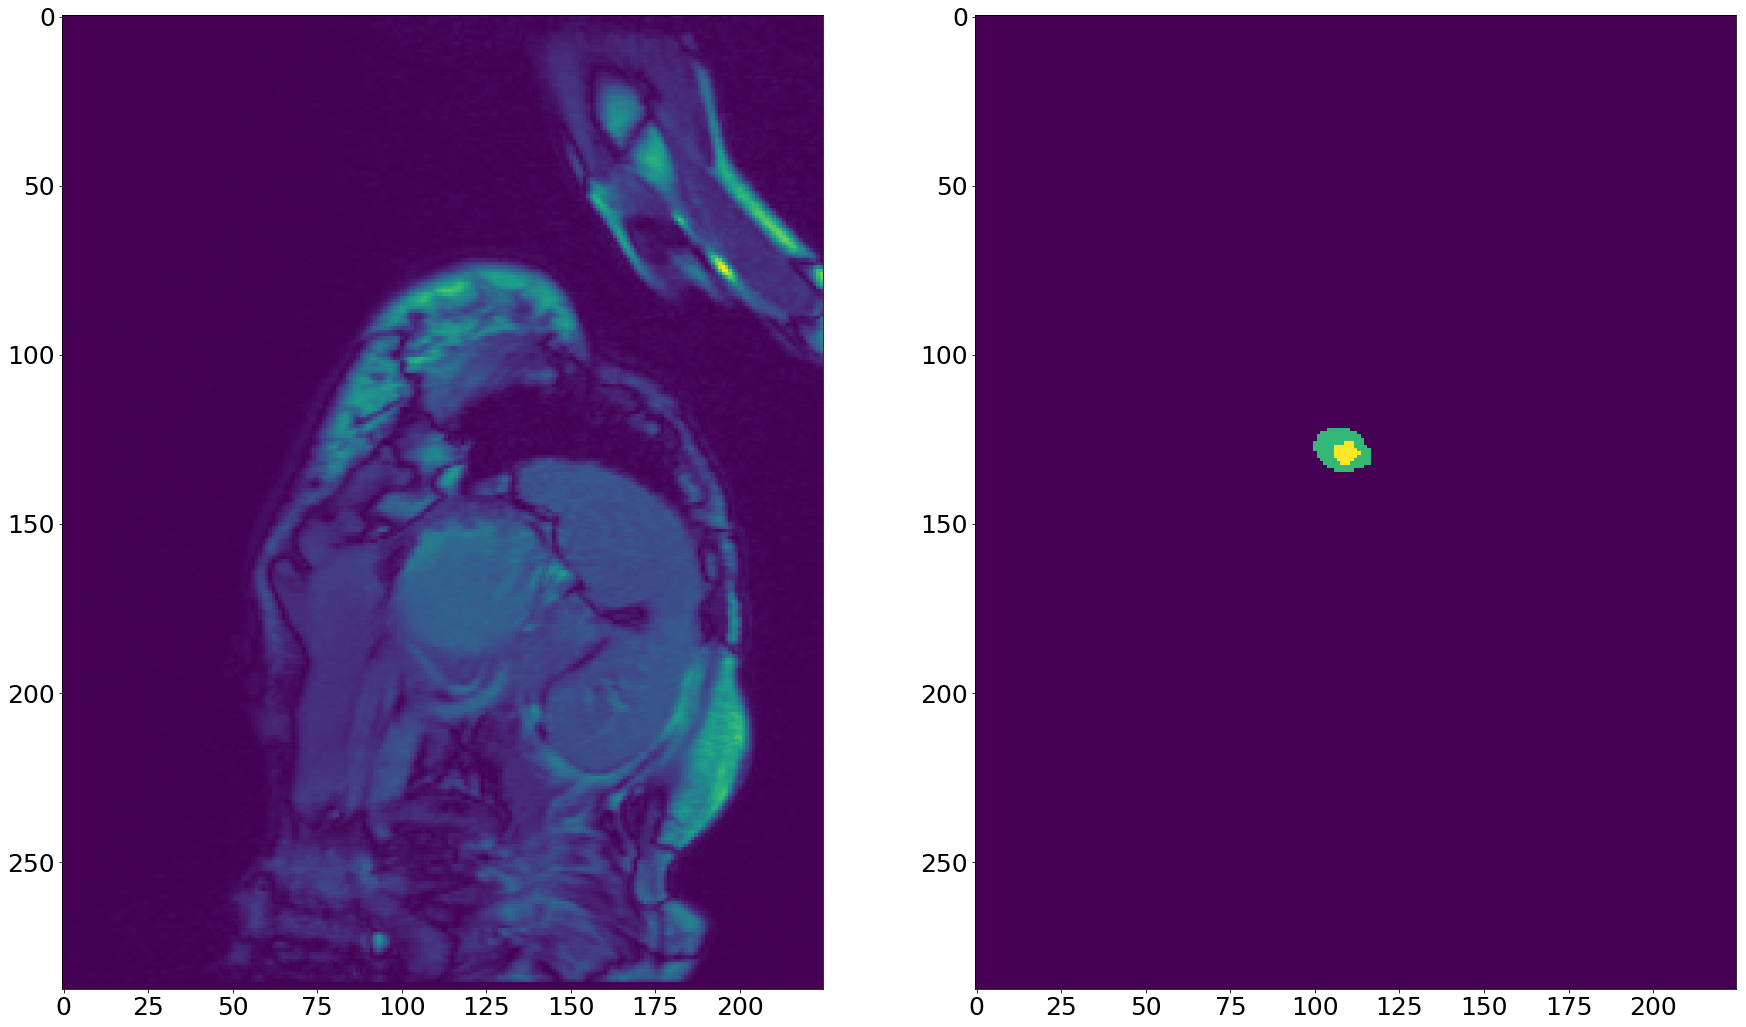

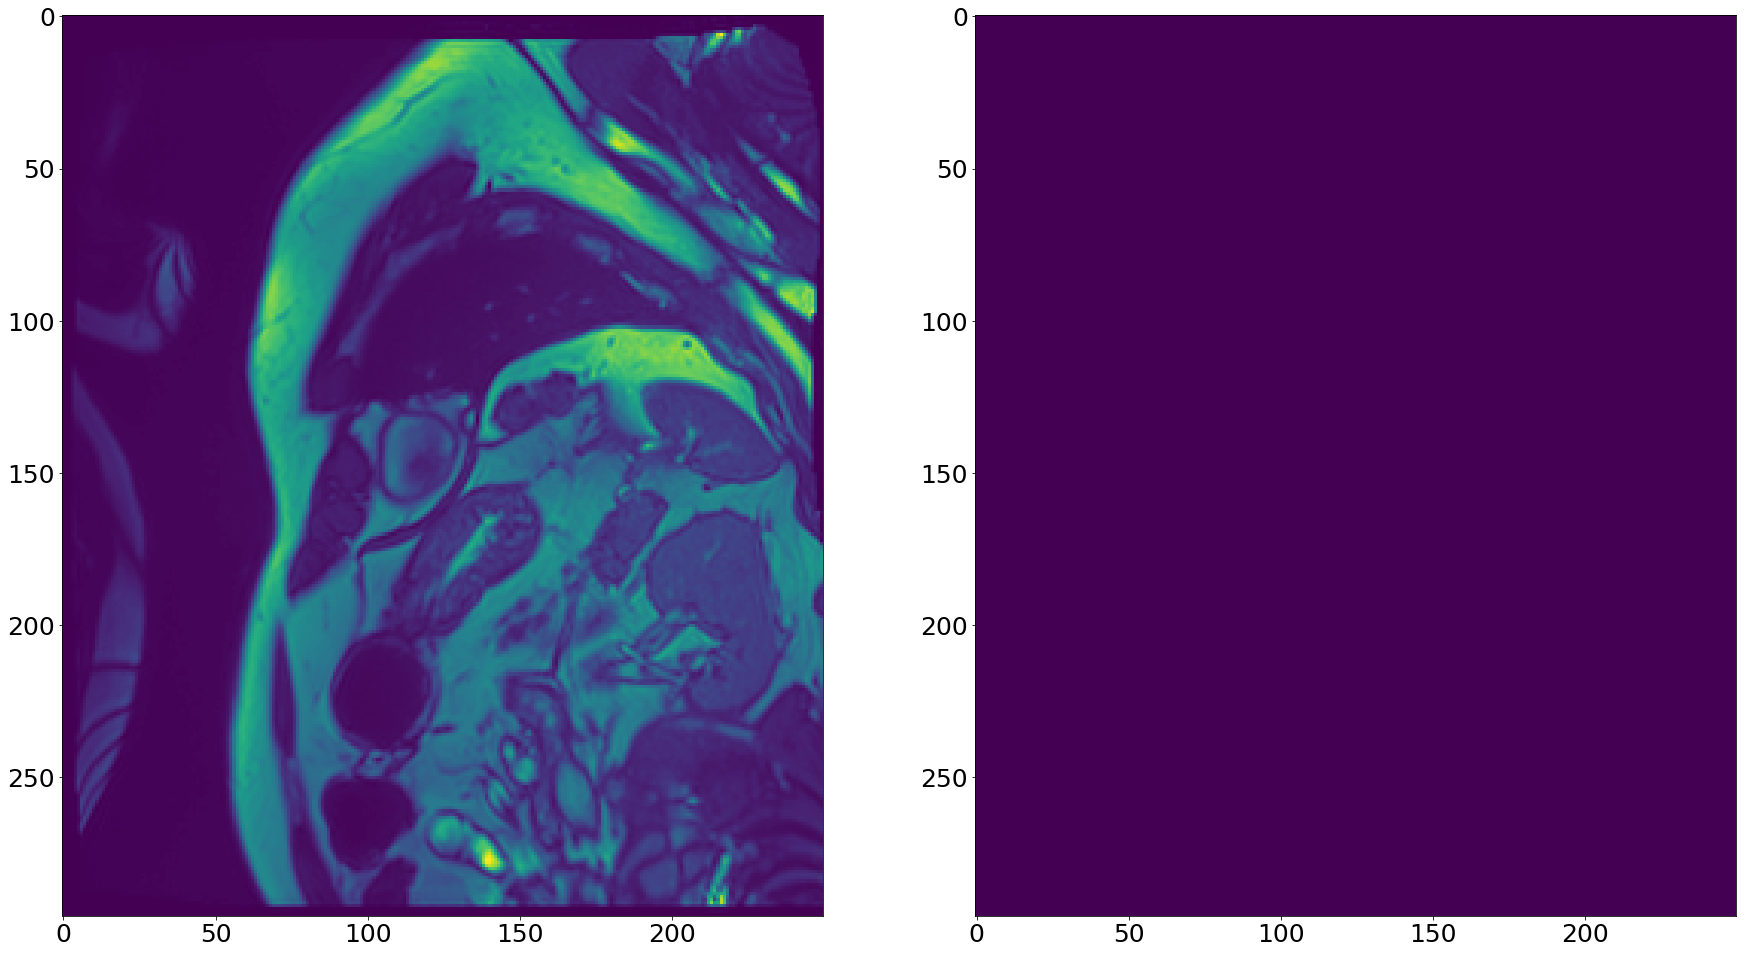

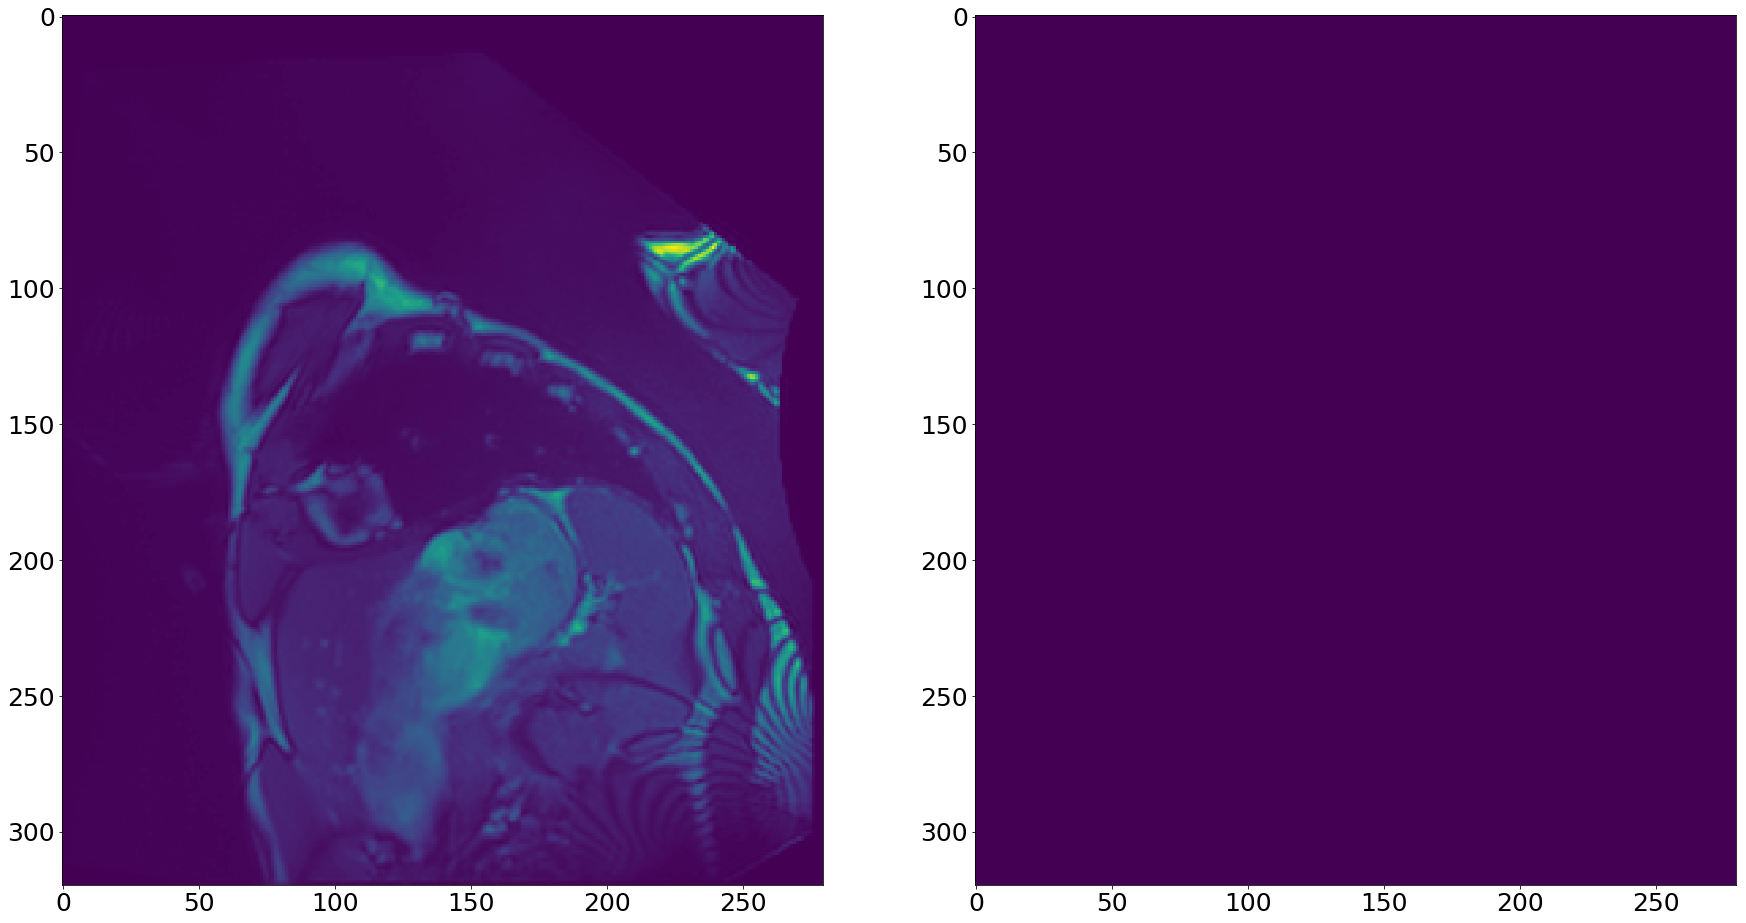

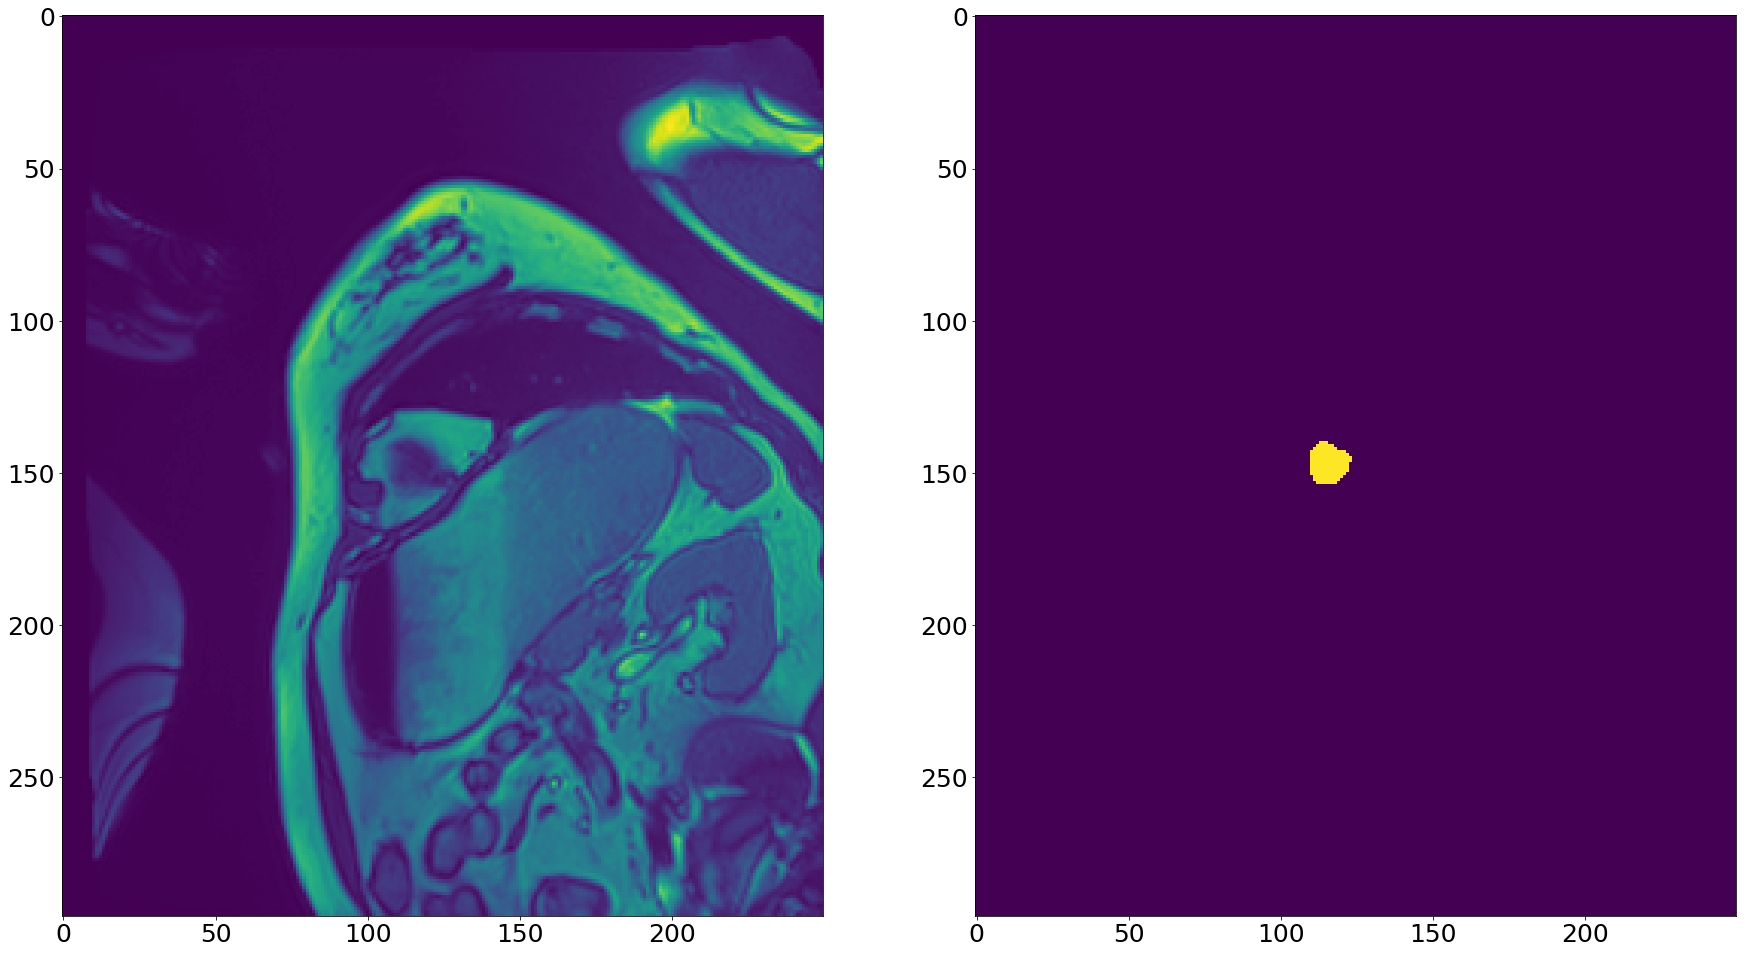

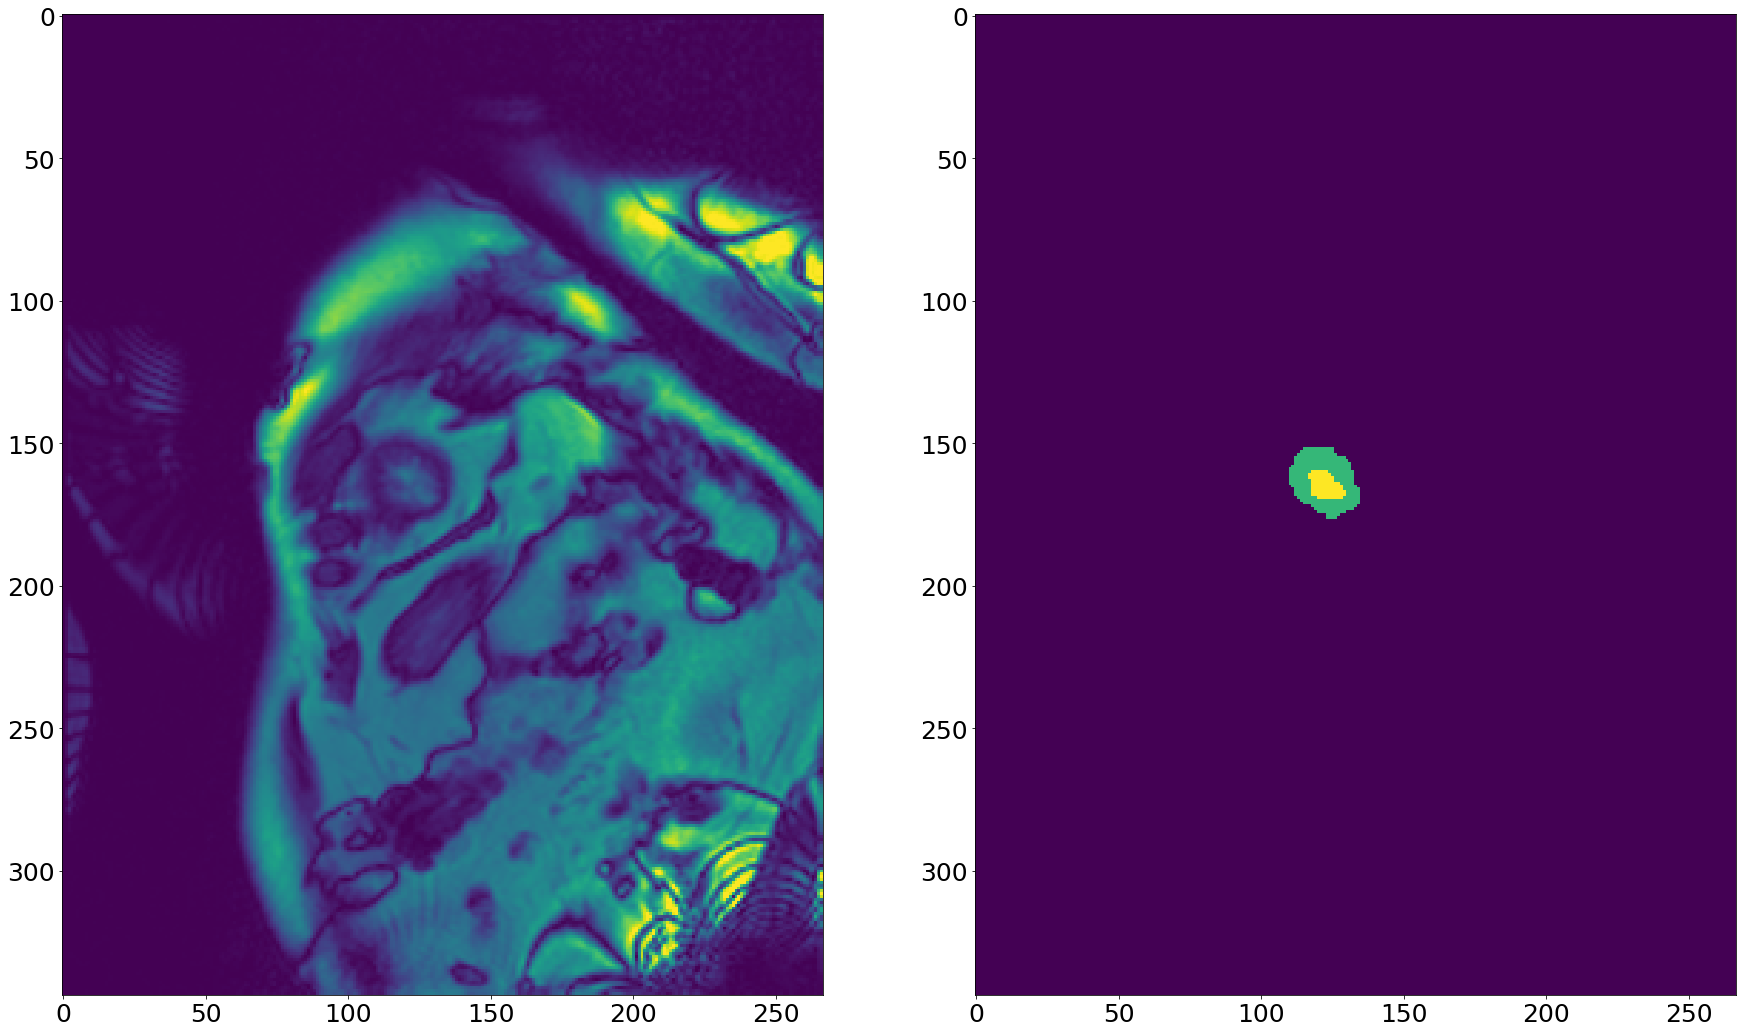

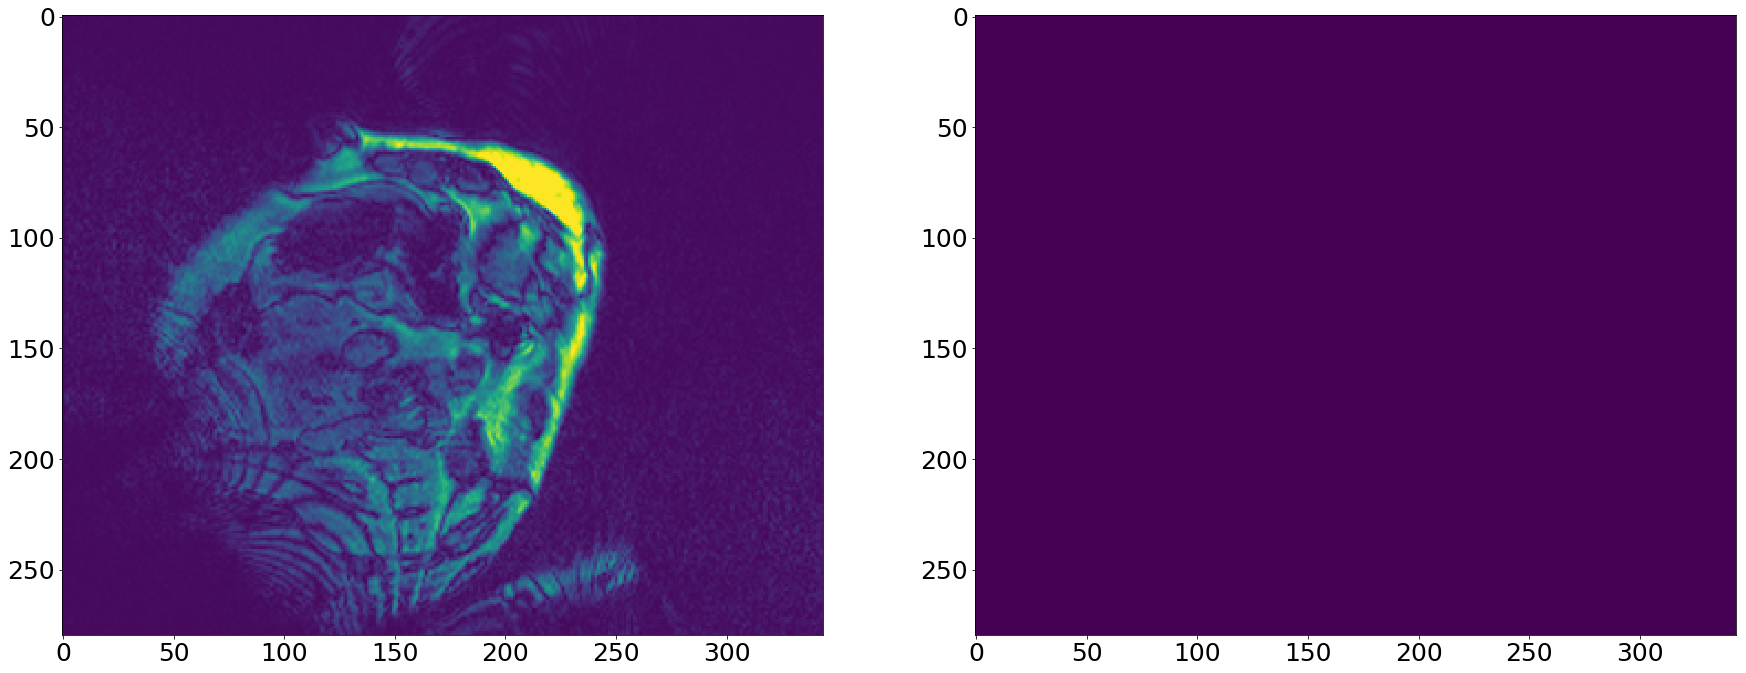

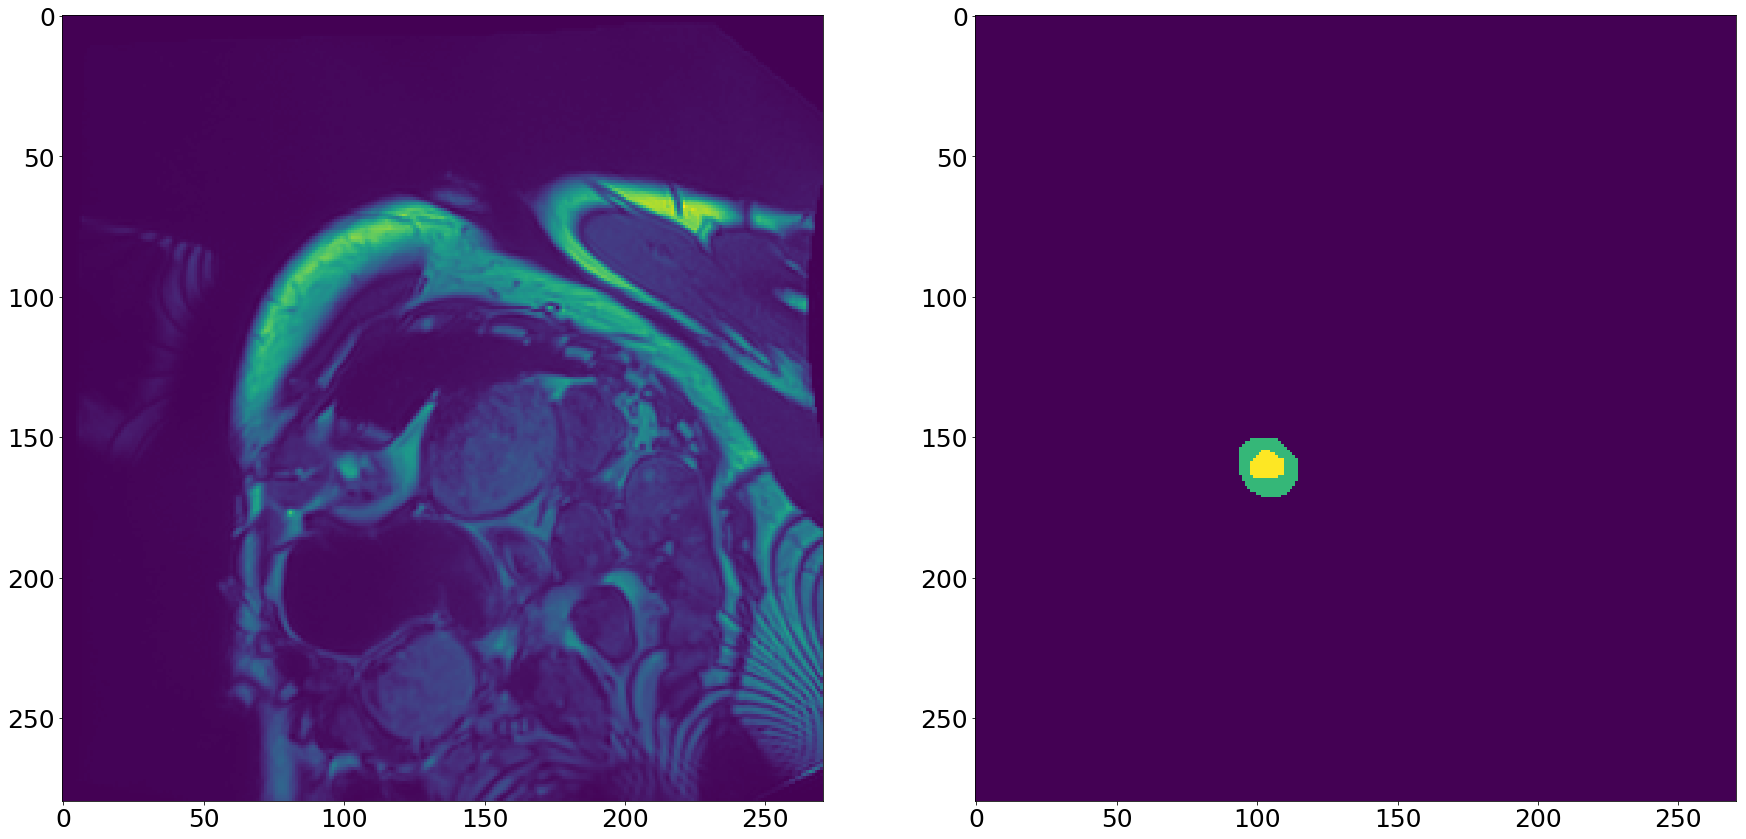

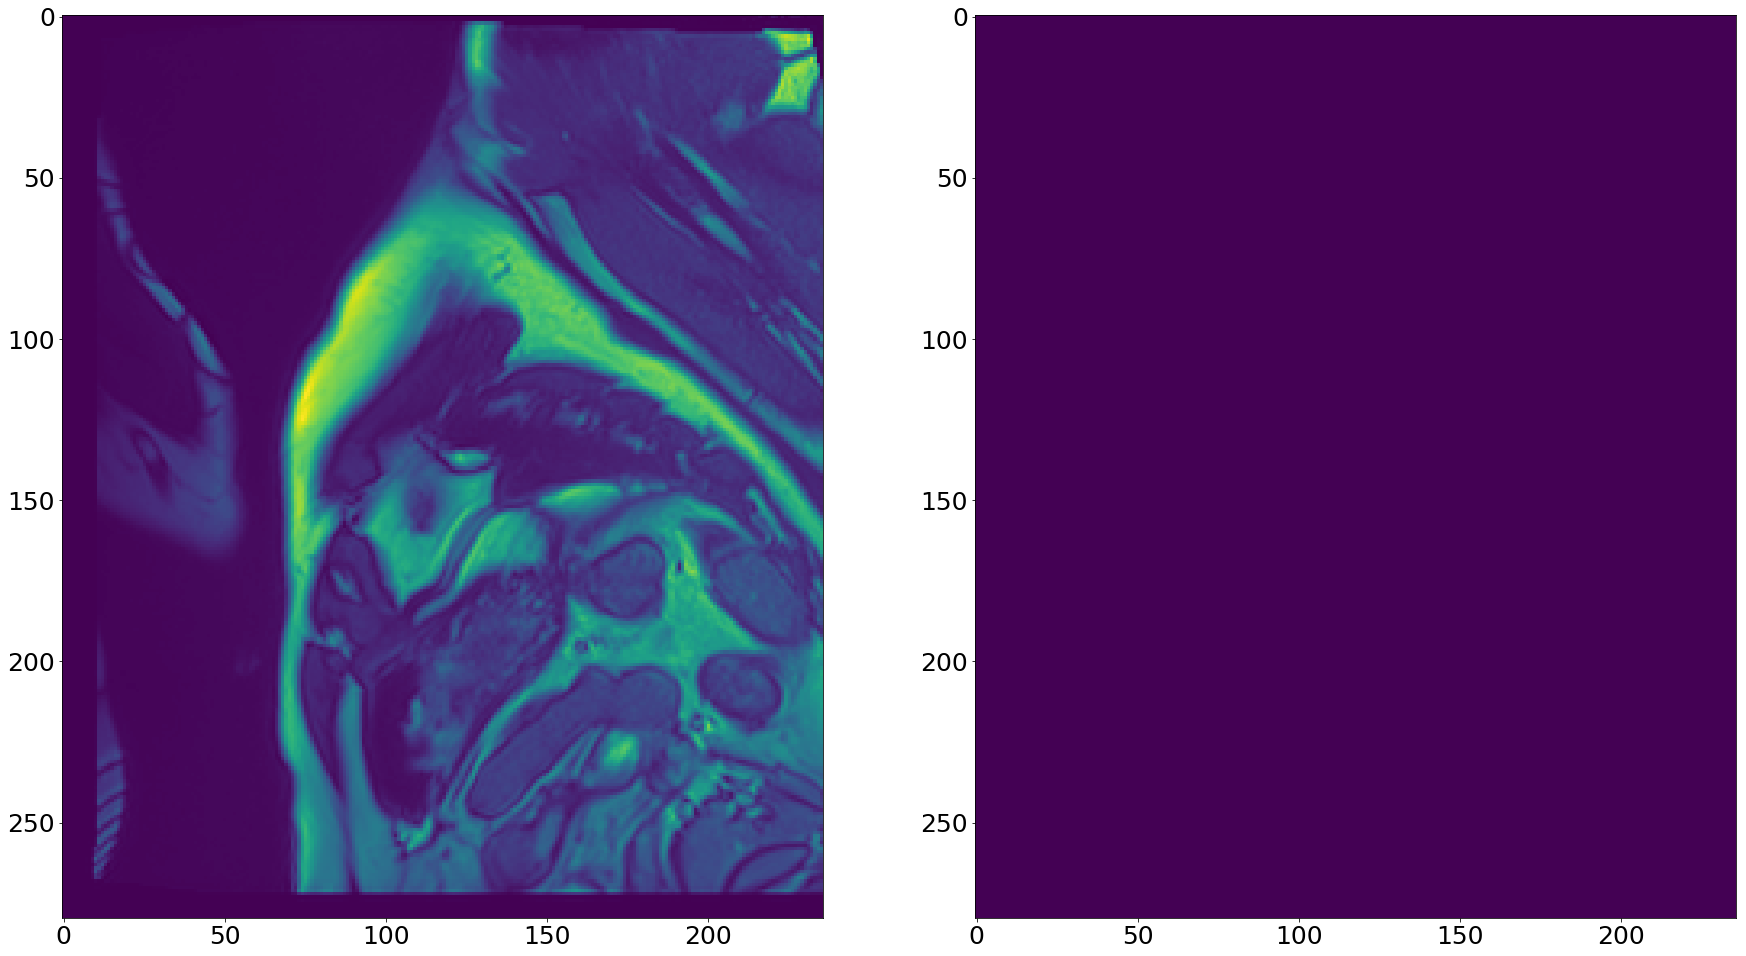

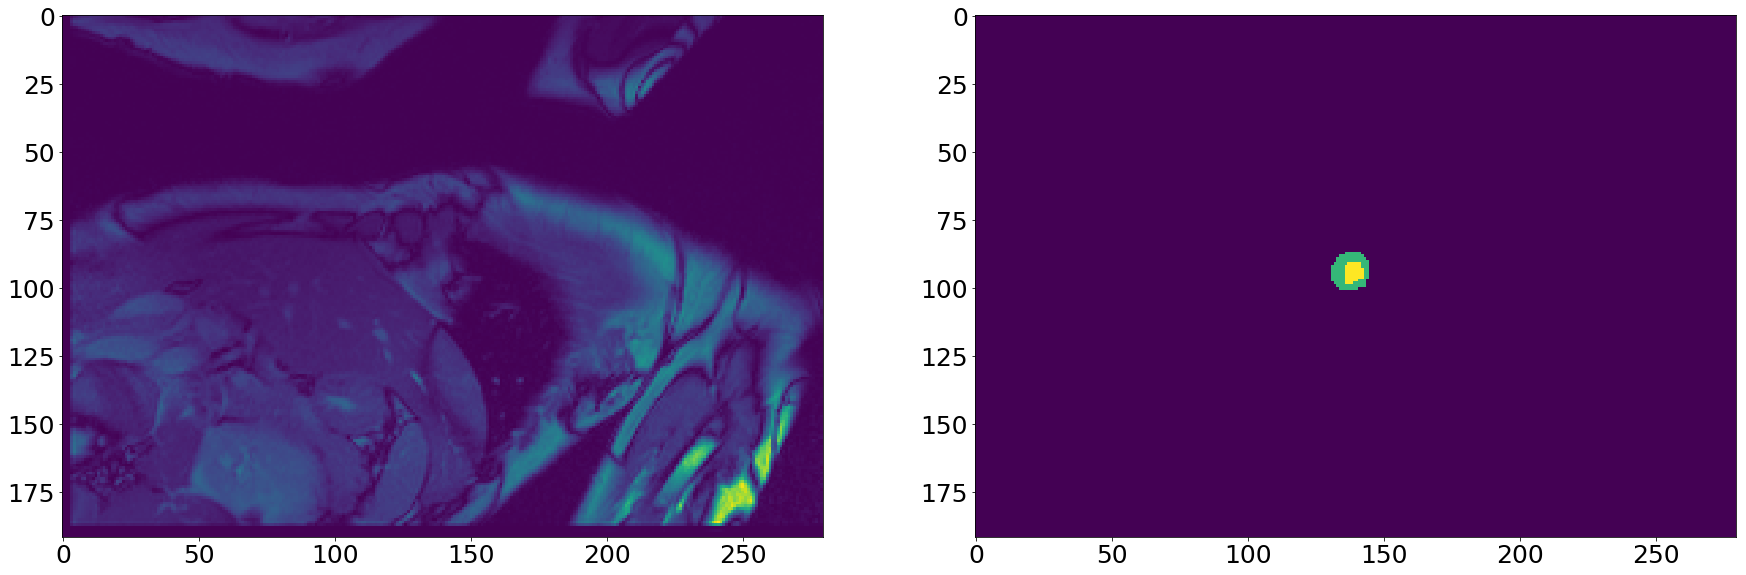

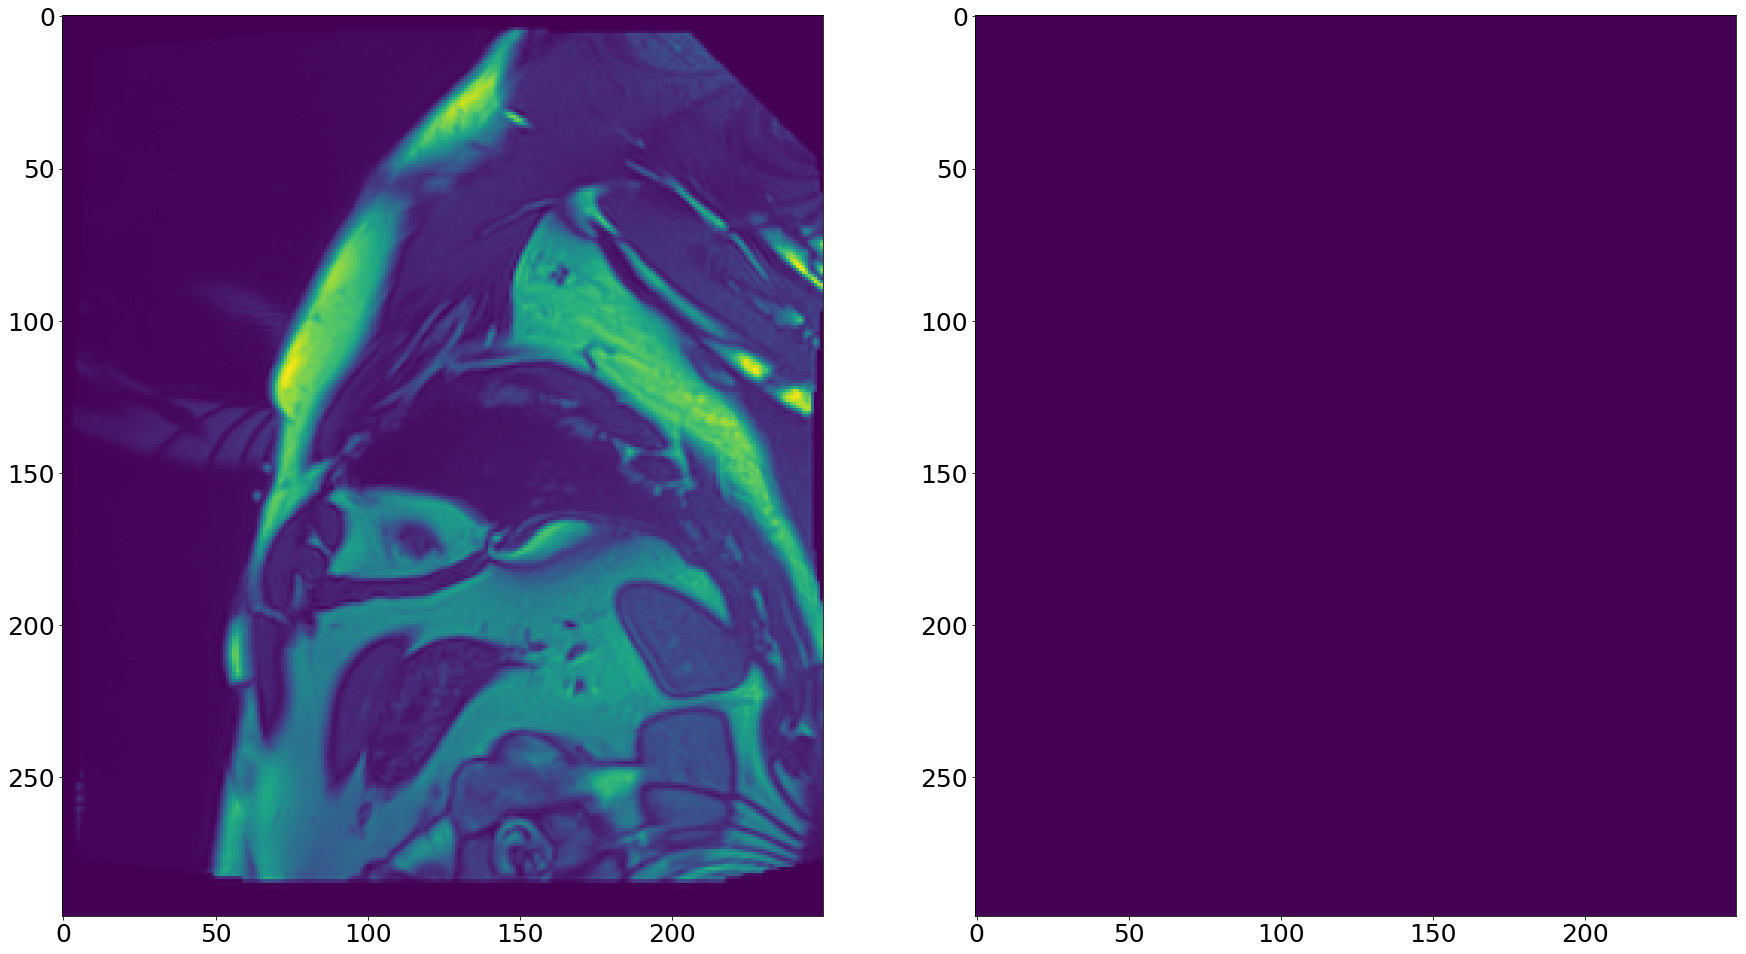

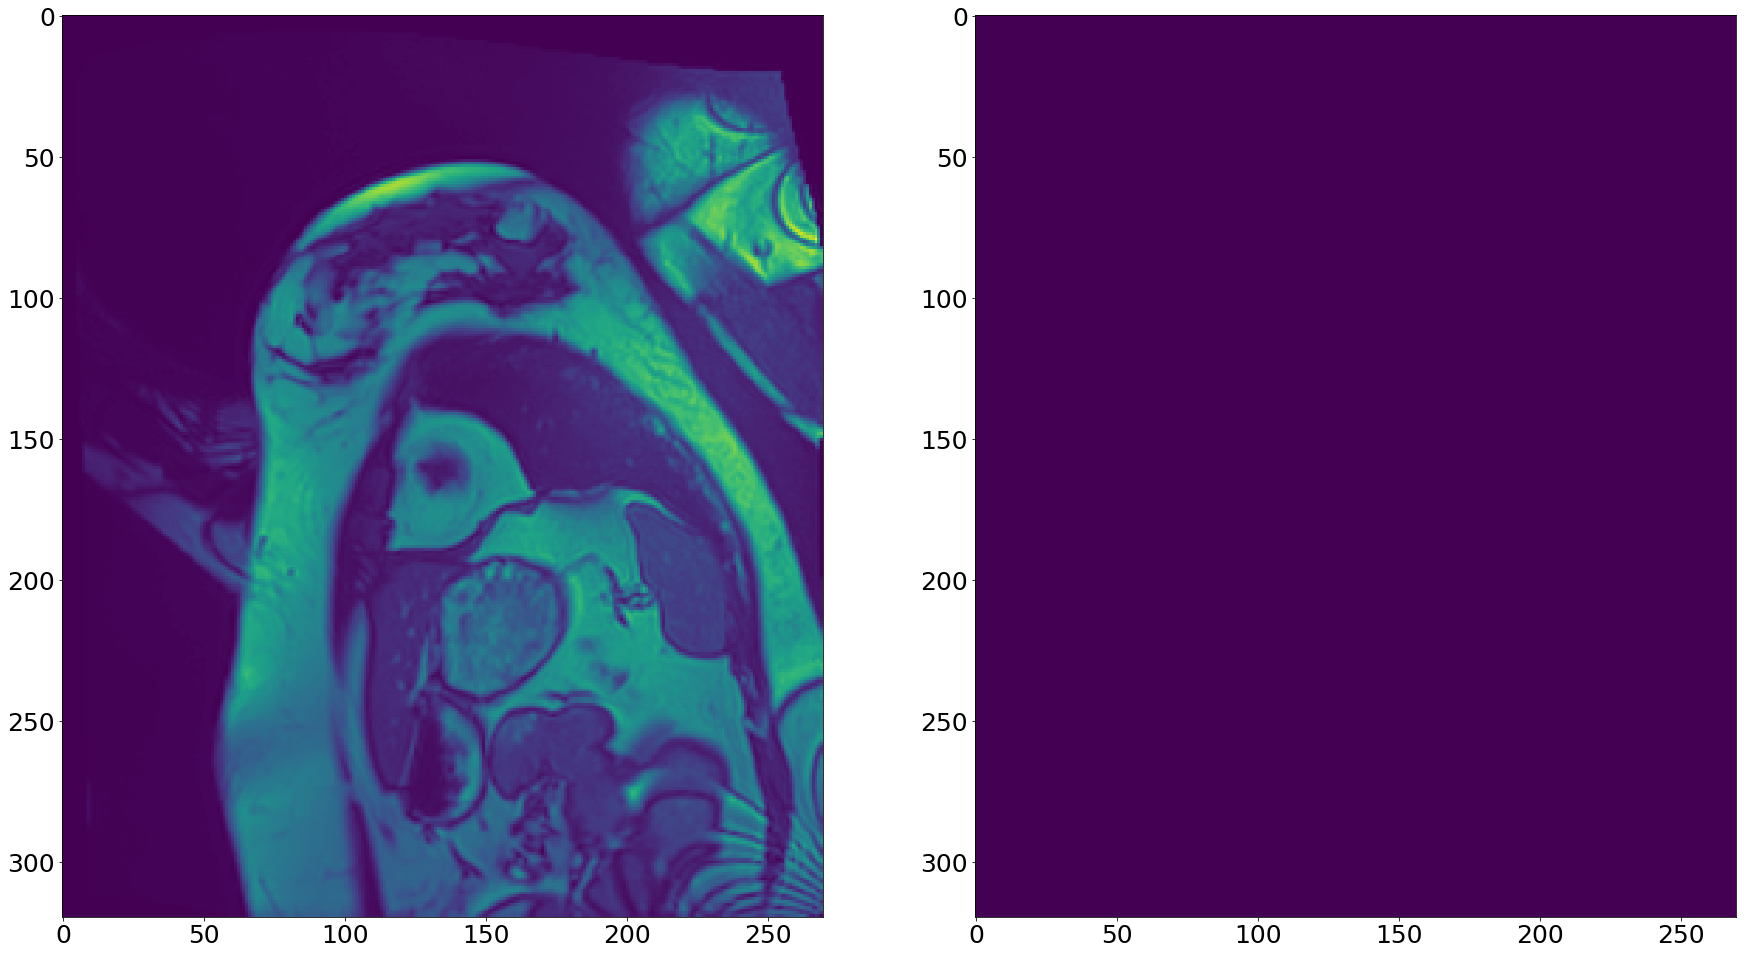

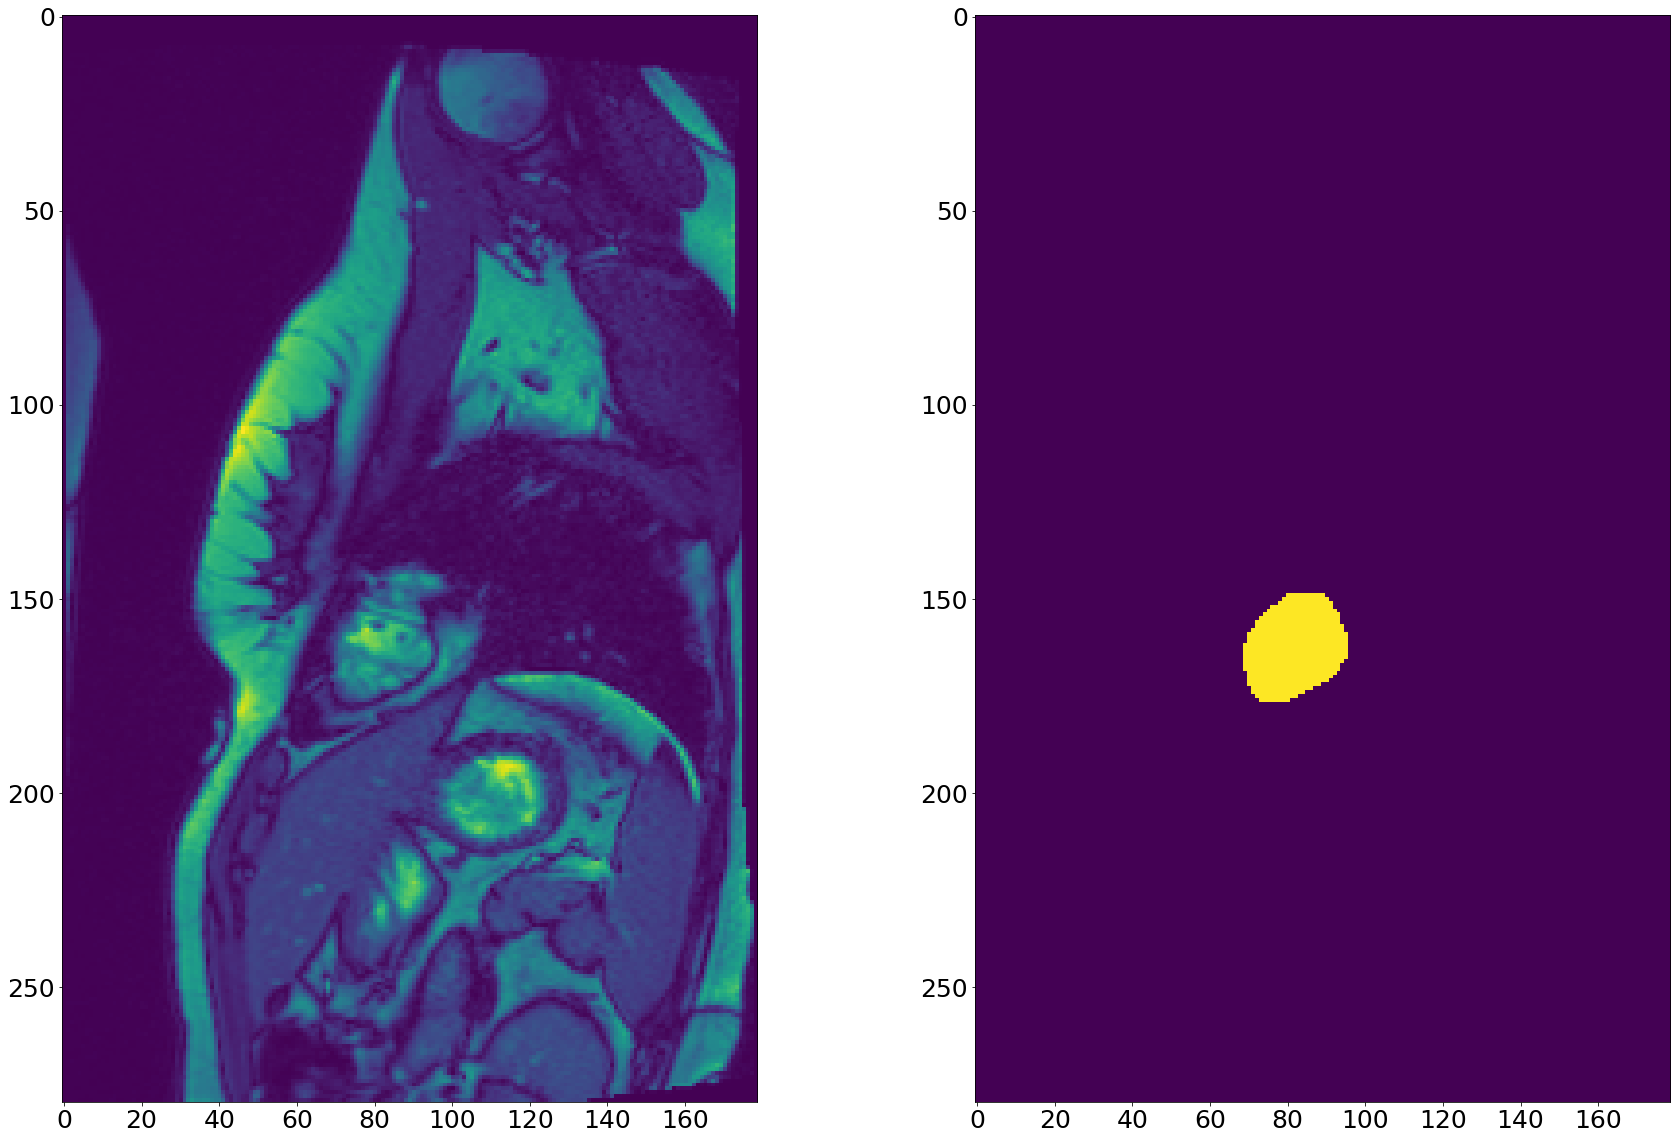

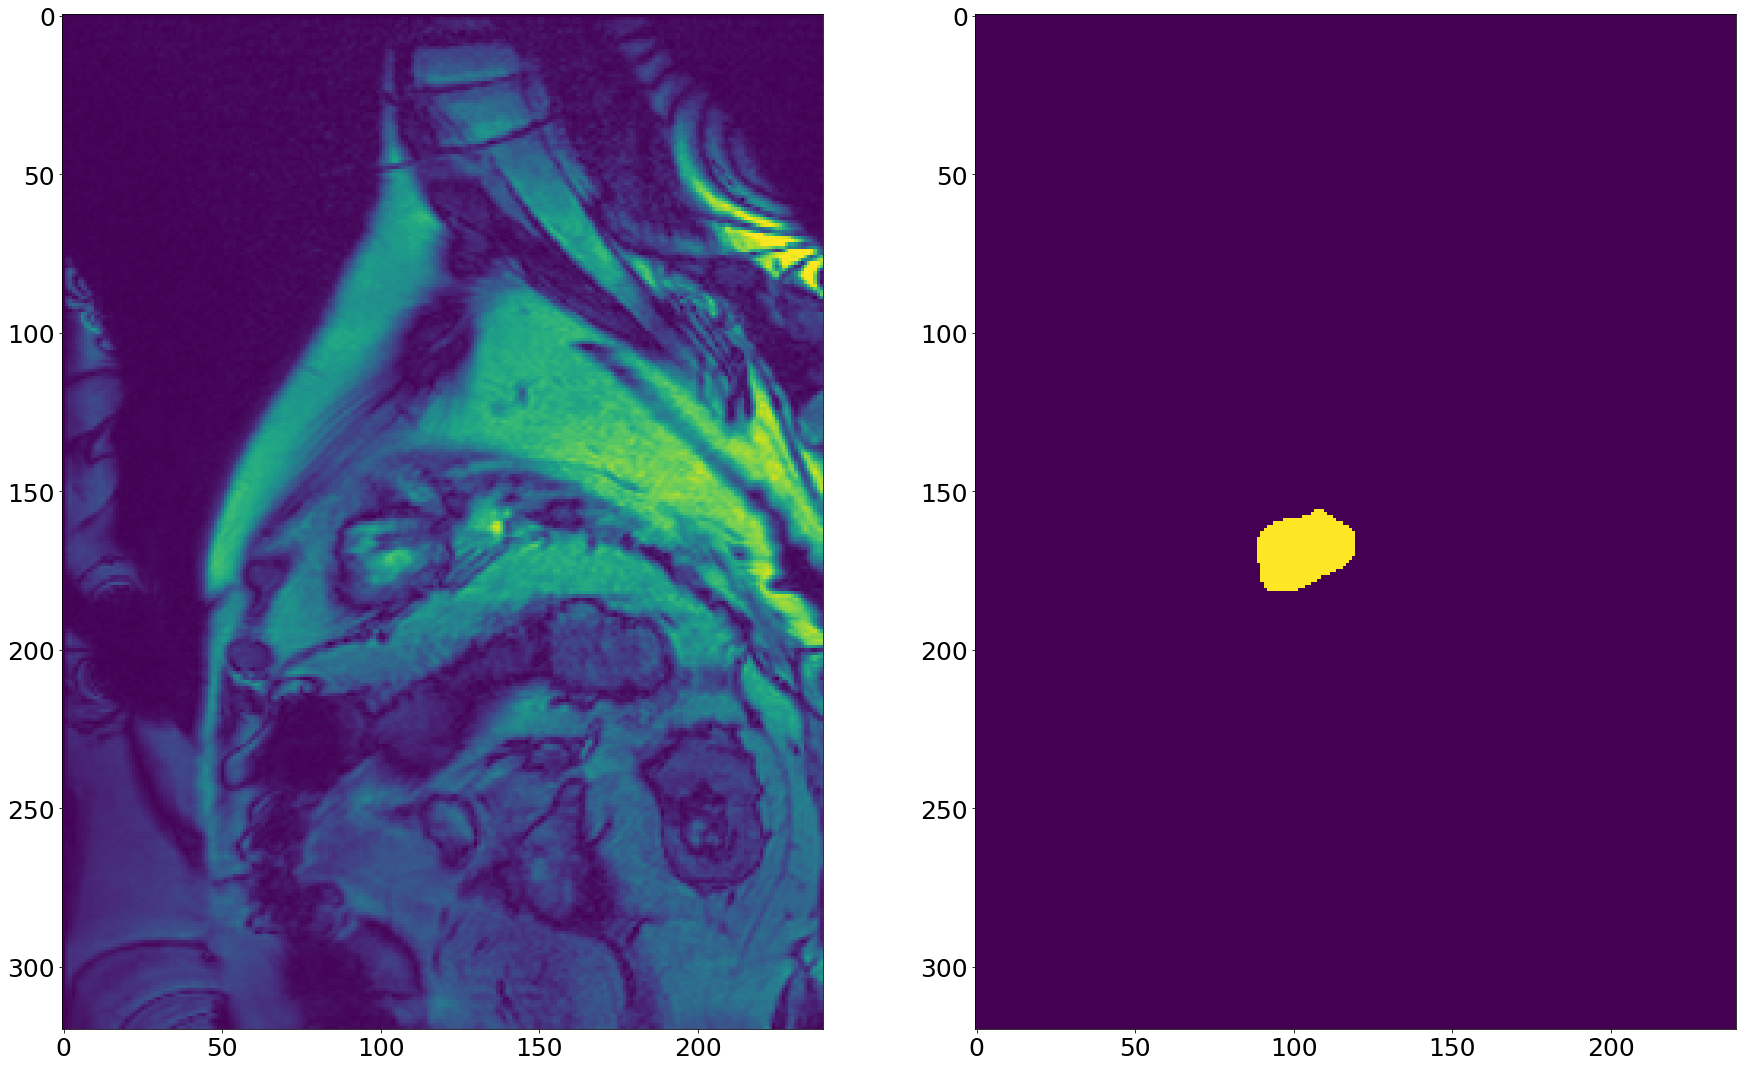

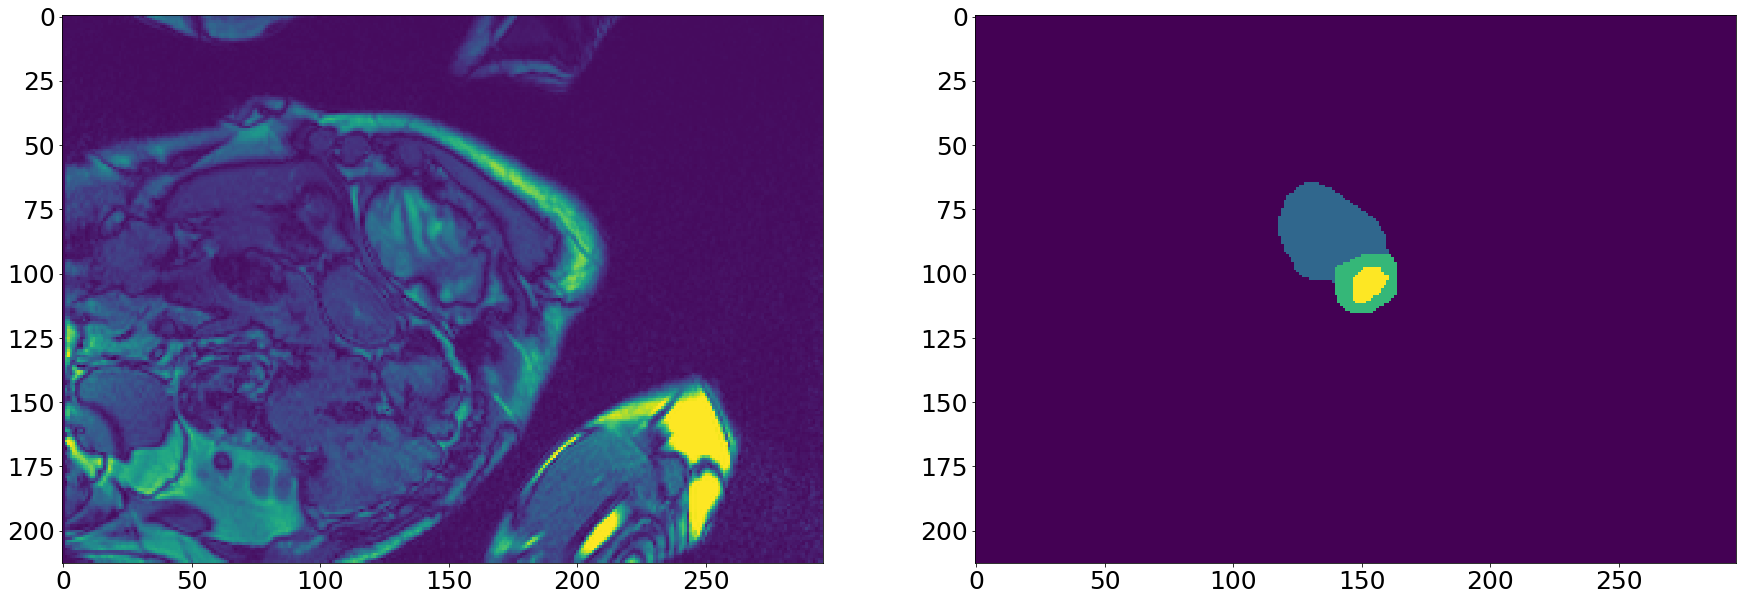

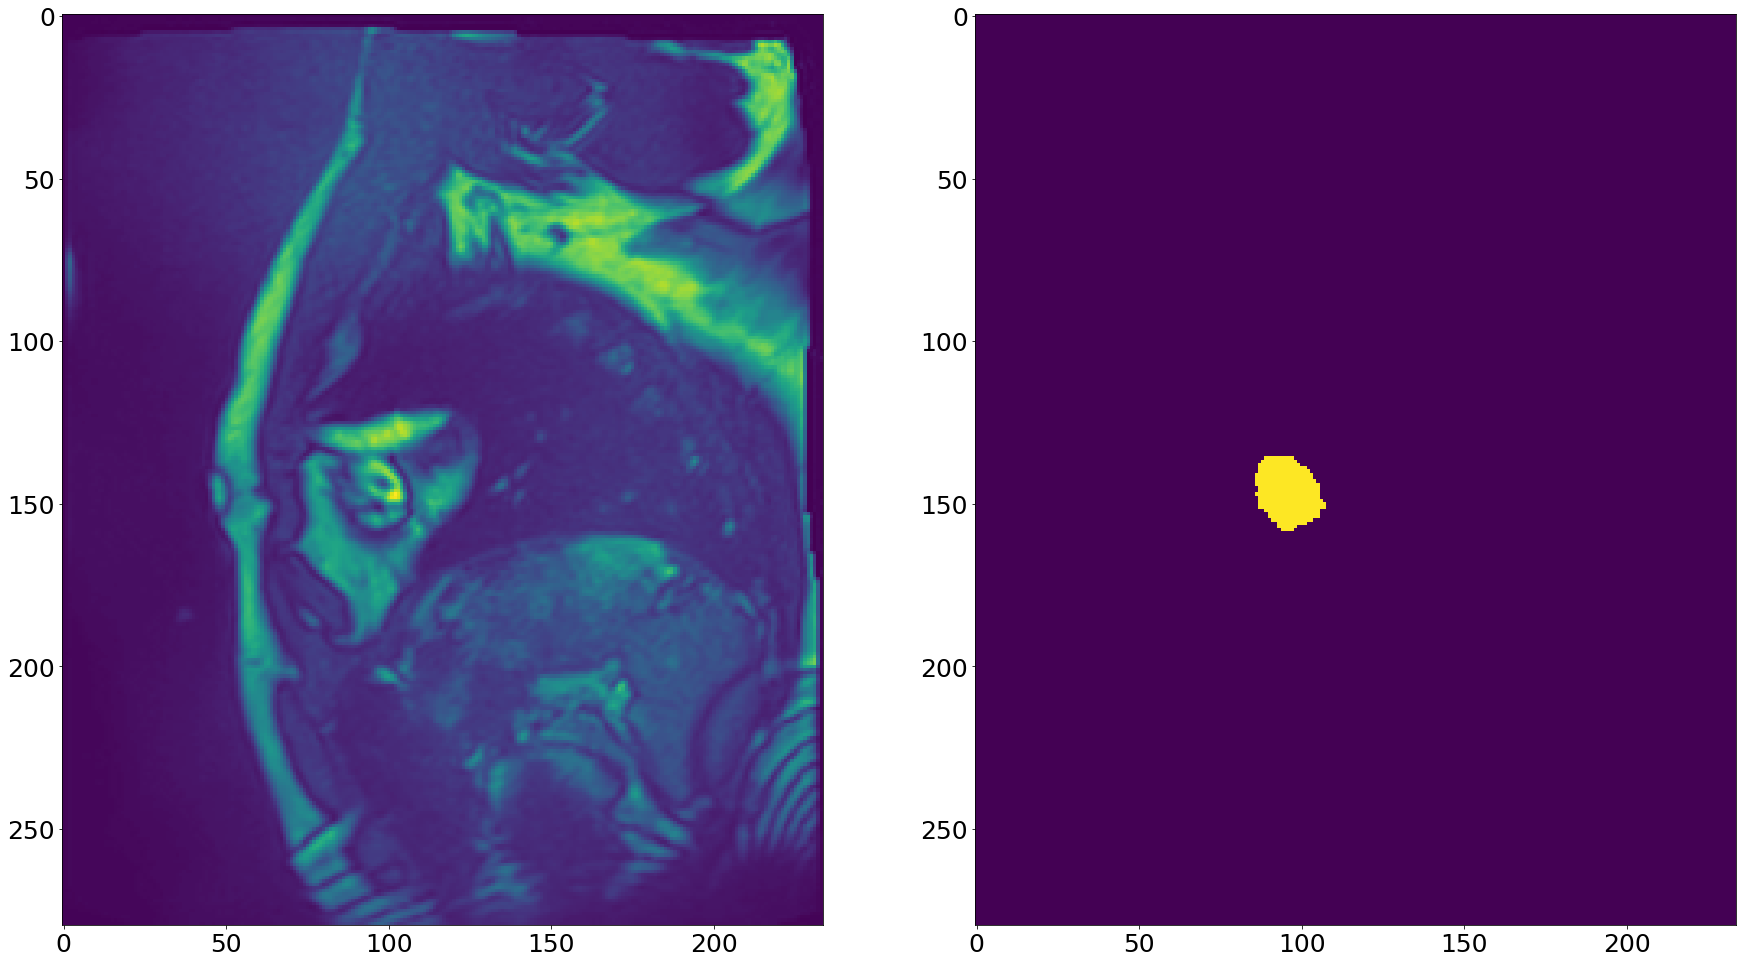

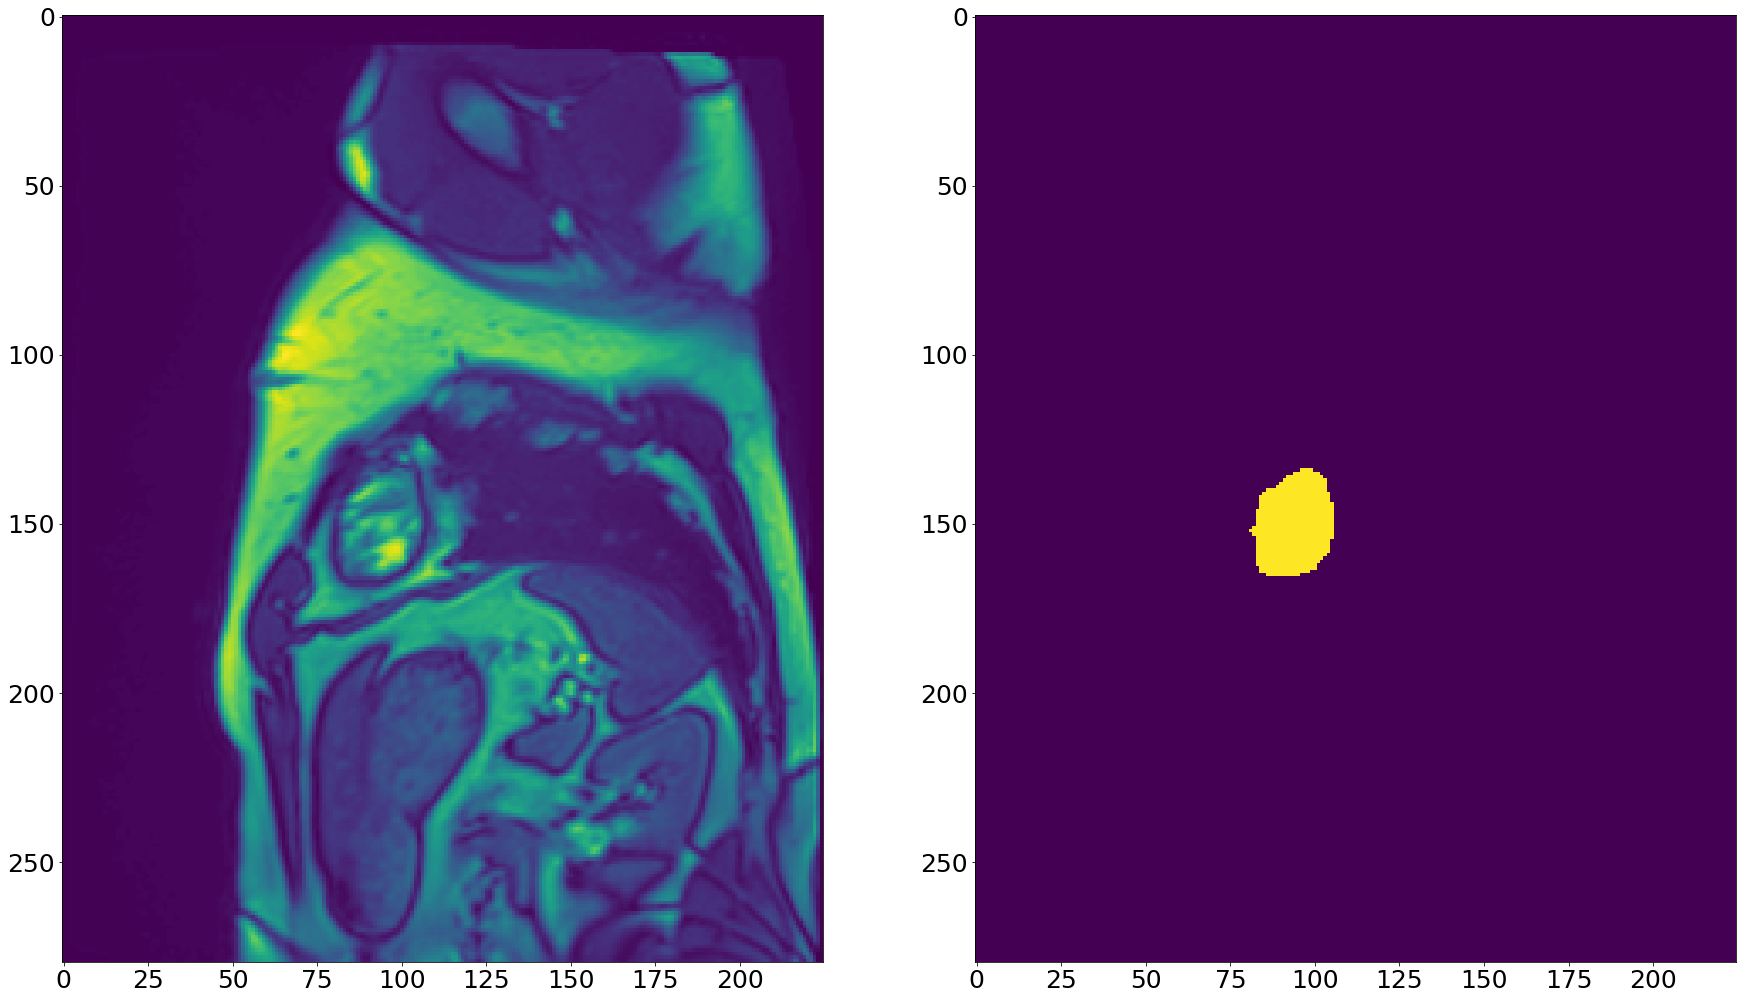

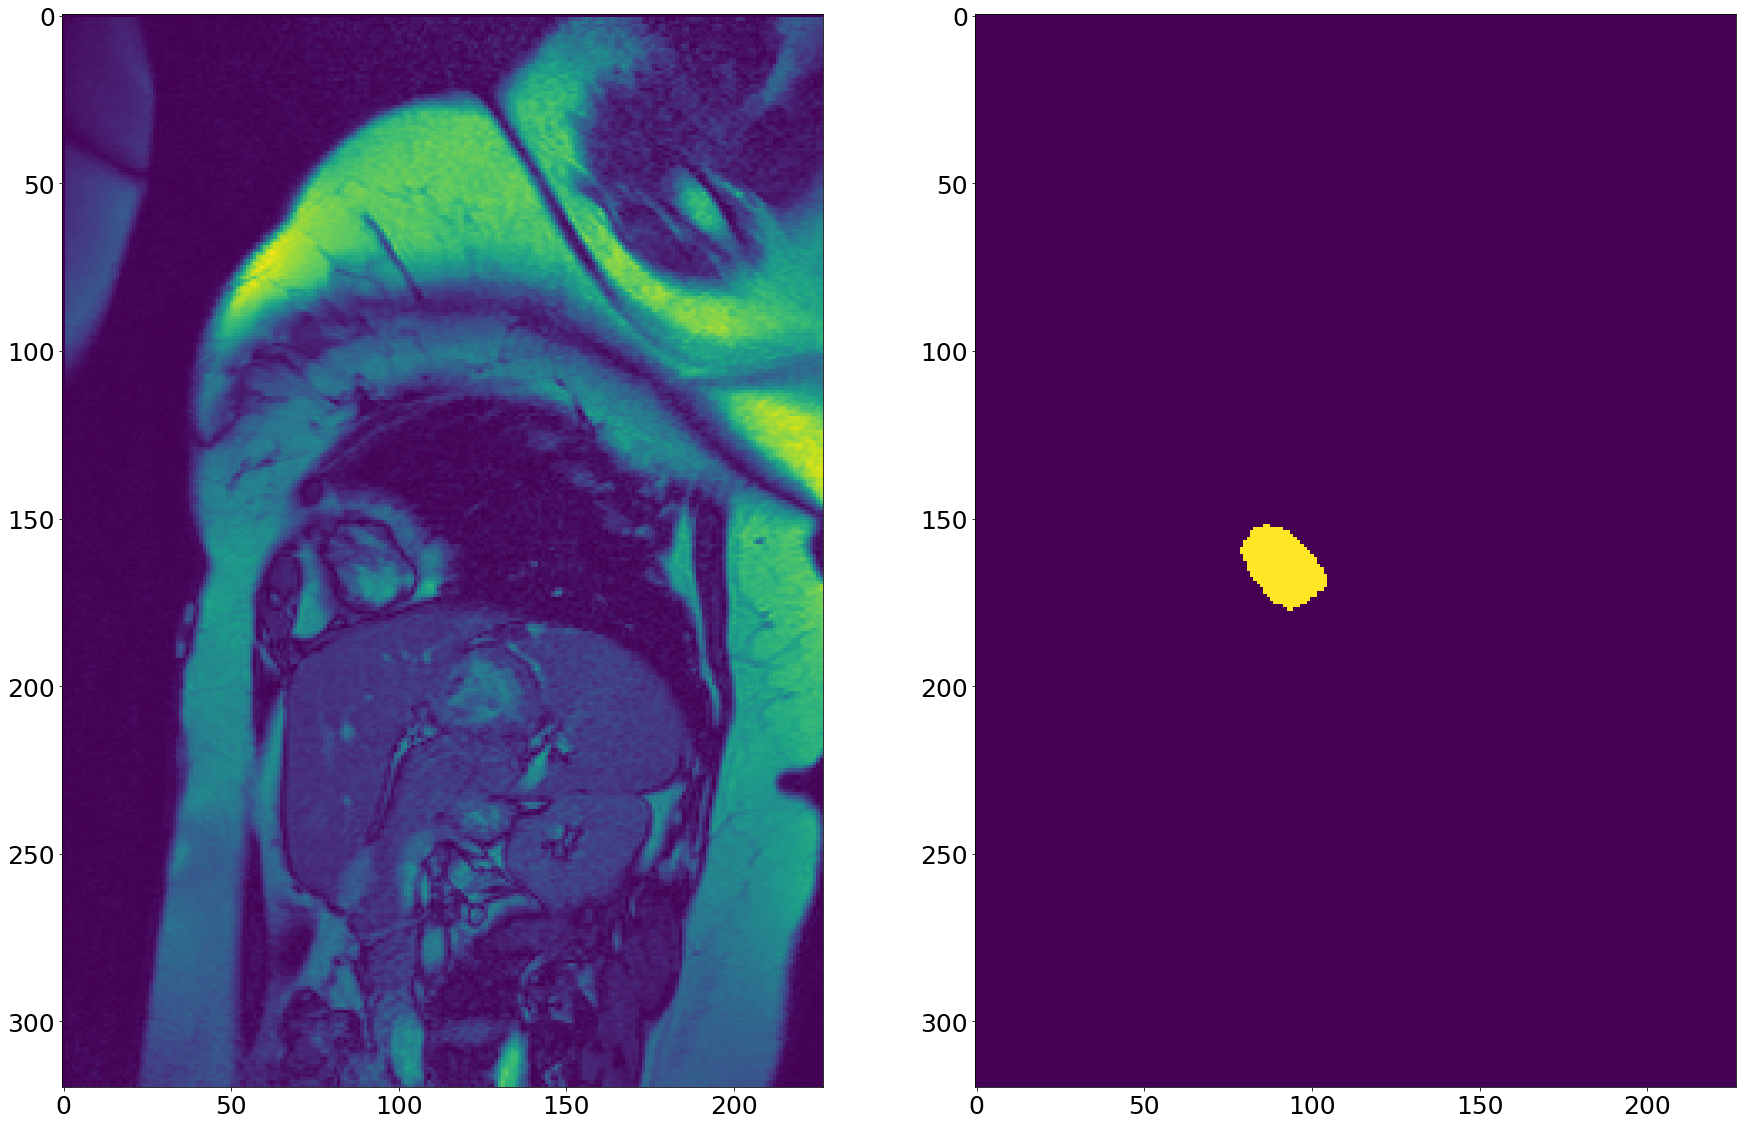

In [21]:
for i in patients:
    plt.figure(figsize=(30,20))    
    plt.subplot(1,2,1)
    plt.imshow(data[i]['ed_data'][-1])    
    plt.subplot(1,2,2)    
    plt.imshow(data[i]['ed_gt'][-1])
    plt.show()

In [8]:
df = pd.read_csv('results_gt_vs_gt_20200213_153219.csv')
#plot_boxplots(df)

In [23]:
df

Name  Dice LV  Volume LV  Err LV(ml)  Dice RV  Volume RV  \
0      patient1_ED      1.0      0.686         0.0      1.0      0.089   
1      patient1_ES      1.0      0.440         0.0      0.0      0.000   
2      patient2_ED      1.0      0.174         0.0      0.0      0.000   
3      patient2_ES      1.0      0.028         0.0      0.0      0.000   
4      patient3_ED      1.0      0.195         0.0      0.0      0.000   
5      patient3_ES      1.0      0.129         0.0      0.0      0.000   
6      patient4_ED      1.0      0.187         0.0      0.0      0.000   
7      patient4_ES      1.0      0.105         0.0      0.0      0.000   
8      patient5_ED      1.0      0.297         0.0      1.0      0.127   
9      patient5_ES      1.0      0.267         0.0      0.0      0.000   
10     patient6_ED      1.0      0.283         0.0      1.0      0.328   
11     patient6_ES      1.0      0.274         0.0      0.0      0.000   
12     patient7_ED      1.0      0.589         0.0      1.0      0.535   
13     patient7_ES      1.0      0.464         0.0      1.0      0.441   
14     patient8_ED      1.0      0.251         0.0      0.0      0.000   
15     patient8_ES      1.0      0.076         0.0      0.0      0.000   
16     patient9_ED      1.0      0.645         0.0      0.0      0.000   
17     patient9_ES      1.0      0.425         0.0      0.0      0.000   
18    patient10_ED      1.0      0.241         0.0      1.0      0.274   
19    patient10_ES      1.0      0.115         0.0      0.0      0.000   
20    patient11_ED      1.0      0.470         0.0      1.0      0.312   
21    patient11_ES      1.0      0.428         0.0      1.0      0.207   
22    patient12_ED      1.0      0.630         0.0      0.0      0.000   
23    patient12_ES      1.0      0.331         0.0      0.0      0.000   
24    patient13_ED      1.0      0.336         0.0      0.0      0.000   
25    patient13_ES      1.0      0.077         0.0      0.0      0.000   
26    patient14_ED      1.0      0.658         0.0      0.0      0.000   
27    patient14_ES      1.0      0.389         0.0      0.0      0.000   
28    patient15_ED      1.0      0.120         0.0      0.0      0.000   
29    patient15_ES      0.0      0.000         0.0      0.0      0.000   
..             ...      ...        ...         ...      ...        ...   
170   patient86_ED      0.0      0.000         0.0      1.0      0.590   
171   patient86_ES      0.0      0.000         0.0      1.0      0.721   
172   patient87_ED      1.0      0.141         0.0      1.0      1.072   
173   patient87_ES      1.0      0.097         0.0      1.0      0.446   
174   patient88_ED      1.0      0.069         0.0      1.0      0.124   
175   patient88_ES      0.0      0.000         0.0      0.0      0.000   
176   patient89_ED      1.0      0.373         0.0      1.0      0.089   
177   patient89_ES      1.0      0.063         0.0      1.0      0.046   
178   patient90_ED      1.0      0.186         0.0      1.0      0.932   
179   patient90_ES      0.0      0.000         0.0      1.0      0.170   
180   patient91_ED      1.0      0.027         0.0      1.0      0.405   
181   patient91_ES      0.0      0.000         0.0      1.0      0.120   
182   patient92_ED      0.0      0.000         0.0      1.0      0.359   
183   patient92_ES      0.0      0.000         0.0      0.0      0.000   
184   patient93_ED      0.0      0.000         0.0      1.0      0.608   
185   patient93_ES      0.0      0.000         0.0      1.0      0.015   
186   patient94_ED      1.0      0.289         0.0      0.0      0.000   
187   patient94_ES      1.0      0.033         0.0      0.0      0.000   
188   patient95_ED      1.0      0.213         0.0      1.0      0.288   
189   patient95_ES      0.0      0.000         0.0      0.0      0.000   
190   patient96_ED      1.0      0.220         0.0      1.0      0.613   
191   patient96_ES      1.0      0.045         0.0      1.0      0.228   
192   patient97_ED

In [24]:
len(df)

200

In [496]:
df = pd.read_csv('results__OFFICIAL_GT_VS_GT_20200214_150001.csv')
df
calculate_results('results__OFFICIAL_GT_VS_GT_20200214_150001.csv', loss=False)

Dice LV  => ED: 73.0  %, ES:   73.0%
Dice RV  => ED: 37.5  %, ES:   37.5%
Dice MYO => ED: 80.5  %, ES:   80.5%
Dice LV: mean: 0.717, median: 1.0
Dice RV: mean: 0.38, median: 0.0
Dice MYO: mean: 0.791, median: 1.0
Overall dice: mean: 0.629, median: 1.0


In [497]:
df['Types'] = [x.split('_')[2] for x in df['Name'].values]

In [11]:
lower = []
pats = {}
for col in [c for c in df.columns if "Dice" in c]:
    patients_d = [int(x.split('_')[0].replace('patient','')) for x in df[df['Types'] == 'ED'][df[col] < 1.]['Name']]
    patients_s = [int(x.split('_')[0].replace('patient','')) for x in df[df['Types'] == 'ES'][df[col] < 1.]['Name']]
    pats[col] = {'ED':patients_d, "ES": patients_s}
    lower.extend(patients_d)
    lower.extend(patients_s)

In [12]:
print("There are {} data samples where groundtruth masks are not equal to 1. according to Dice.".format(len(set(lower))))

There are 79 data samples where groundtruth masks are not equal to 1. according to Dice.


In [13]:
pats.keys()

dict_keys(['Dice MYO', 'Dice RV', 'Dice LV'])

In [14]:
items = []
for key in pats.keys():
    items.append(len(pats[key]['ED'])*[key+' ED'])
    items.append(len(pats[key]['ES'])*[key+' ES'])    

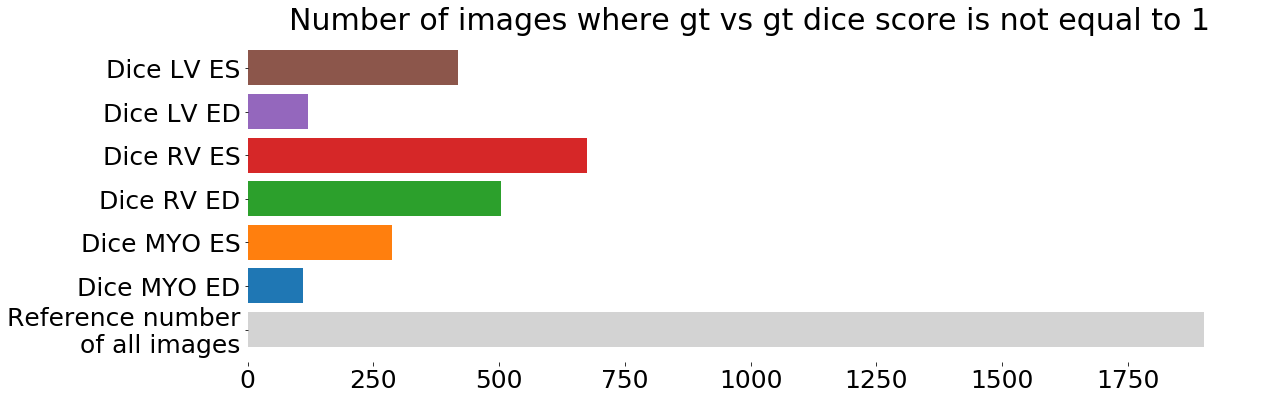

In [15]:
plt.figure(figsize=(18,6))
plt.barh("Reference number\nof all images", len(df), color="#d3d3d3")
for key in pats.keys():
    plt.barh(key+' ED',len(pats[key]['ED']))
    plt.barh(key+' ES',len(pats[key]['ES']))
plt.title("Number of images where gt vs gt dice score is not equal to 1")
plt.box("off")
plt.show()

In [16]:
def collect_ids_to_evaluate(df):
    pats = {}
    for col in [c for c in df.columns if "Dice" in c]:
        pats[col] = [x for x in df[df[col] == 1.]['Name']]
    return pats

In [17]:
pats = collect_ids_to_evaluate(df)

In [18]:
df = pd.read_csv('results_OFFICIAL_RESULT_MODEL_10th_20200214_150130.csv')
df

Name   Dice LV  Volume LV  Err LV(ml)   Dice RV  Volume RV  \
0       patient1_0_ED  0.969875      0.675      -0.011  0.794521      0.130   
1       patient1_0_ES  0.934884      0.420      -0.020  0.000000      0.000   
2       patient1_1_ED  0.969875      0.675      -0.011  0.794521      0.130   
3       patient1_1_ES  0.934884      0.420      -0.020  0.000000      0.000   
4       patient1_2_ED  0.969875      0.675      -0.011  0.794521      0.130   
5       patient1_2_ES  0.934884      0.420      -0.020  0.000000      0.000   
6       patient1_3_ED  0.969875      0.675      -0.011  0.794521      0.130   
7       patient1_3_ES  0.934884      0.420      -0.020  0.000000      0.000   
8       patient1_4_ED  0.969875      0.675      -0.011  0.794521      0.130   
9       patient1_4_ES  0.934884      0.420      -0.020  0.000000      0.000   
10      patient1_5_ED  0.969875      0.675      -0.011  0.794521      0.130   
11      patient1_5_ES  0.934884      0.420      -0.020  0.000000      0.000   
12      patient1_6_ED  0.969875      0.675      -0.011  0.794521      0.130   
13      patient1_6_ES  0.934884      0.420      -0.020  0.000000      0.000   
14      patient1_7_ED  0.969875      0.675      -0.011  0.794521      0.130   
15      patient1_7_ES  0.934884      0.420      -0.020  0.000000      0.000   
16      patient1_8_ED  0.969875      0.675      -0.011  0.794521      0.130   
17      patient1_8_ES  0.934884      0.420      -0.020  0.000000      0.000   
18      patient1_9_ED  0.969875      0.675      -0.011  0.794521      0.130   
19      patient1_9_ES  0.934884      0.420      -0.020  0.000000      0.000   
20      patient2_0_ED  0.925714      0.176       0.002  0.000000      0.000   
21      patient2_0_ES  0.881356      0.031       0.003  0.000000      0.000   
22      patient2_1_ED  0.925714      0.176       0.002  0.000000      0.000   
23      patient2_1_ES  0.881356      0.031       0.003  0.000000      0.000   
24      patient2_2_ED  0.925714      0.176       0.002  0.000000      0.000   
25      patient2_2_ES  0.881356      0.031       0.003  0.000000      0.000   
26      patient2_3_ED  0.925714      0.176       0.002  0.000000      0.000   
27      patient2_3_ES  0.881356      0.031       0.003  0.000000      0.000   
28      patient2_4_ED  0.925714      0.176       0.002  0.000000      0.000   
29      patient2_4_ES  0.881356      0.031       0.003  0.000000      0.000   
...               ...       ...        ...         ...       ...        ...   
1872   patient99_9_ED  0.742268      0.037      -0.023  0.741722      0.059   
1873   patient99_9_ES  0.000000      0.000       0.000  0.000000      0.000   
1874  patient99_10_ED  0.742268      0.037      -0.023  0.741722      0.059   
1875  patient99_10_ES  0.000000      0.000       0.000  0.000000      0.000   
1876  patient99_11_ED  0.742268      0.037      -0.023  0.741722      0.059   
1877  patient99_11_ES  0.000000      0.000       0.000  0.000000      0.000   
1878  patient99_12_ED  0.742268      0.037      -0.023  0.741722      0.059   
1879  patient99_12_ES  0.000000      0.000       0.000  0.000000      0.000   
1880  patient99_13_ED  0.742268      0.037      -0.023  0.741722      0.059   
1881  patient99_13_ES  0.000000      0.000       0.000  0.000000      0.000   
1882  patient99_14_ED  0.742268      0.037      -0.023  0.741722      0.059   
1883  patient99_14_ES  0.000000      0.000       0.000  0.000000      0.000   
1884  patient99_15_ED  0.742268      0.037      -0.023  0.741722      0.059   
1885  patient99_15_ES  0.000000      0.000       0.000  0.000000      0.000   
1886  patient100_0_ED  0.000000      0.002       0.002  0.364341      0.094   
1887  patient100_0_ES  0.000000      0.000       0.000  0.000000      0.000   
1888  patient100_1_ED  0.000000      0.002       0.002  0.364341      0.094   
1889  patient100_1_ES  0.000000      0.000       0.000  0.000000      0.000   
1890  patient100_2_ED  0.000000      0.002       0.002  0.364341   

In [19]:
LV = df[df["Name"].isin(pats["Dice LV"])]
RV = df[df["Name"].isin(pats["Dice RV"])]
MYO = df[df["Name"].isin(pats["Dice MYO"])]
ALL = df[df["Name"].isin(set([z for x in pats for z in pats[x] ]))]

lv = report_values(LV, "LV")
rv = report_values(RV, "RV")
myo = report_values(MYO, "MYO")

print("Overall DICE score for these data is: {:.4}".format(np.mean(np.concatenate((lv,rv,myo)))))

print("\nON ALL DATA (GT == 1)")
lv = report_values(ALL, "LV")
rv = report_values(ALL, "RV")      
myo = report_values(ALL, "MYO")

print("Overall DICE score for these data is: {:.4}".format(np.mean(np.concatenate((lv,rv,myo)))))

Dice LV: mean: 0.825, median: 0.905
Dice RV: mean: 0.698, median: 0.898
Dice MYO: mean: 0.8, median: 0.871
Overall DICE score for these data is: 0.7889

ON ALL DATA (GT == 1)
Dice LV: mean: 0.688, median: 0.896
Dice RV: mean: 0.309, median: 0.0
Dice MYO: mean: 0.736, median: 0.863
Overall DICE score for these data is: 0.5775


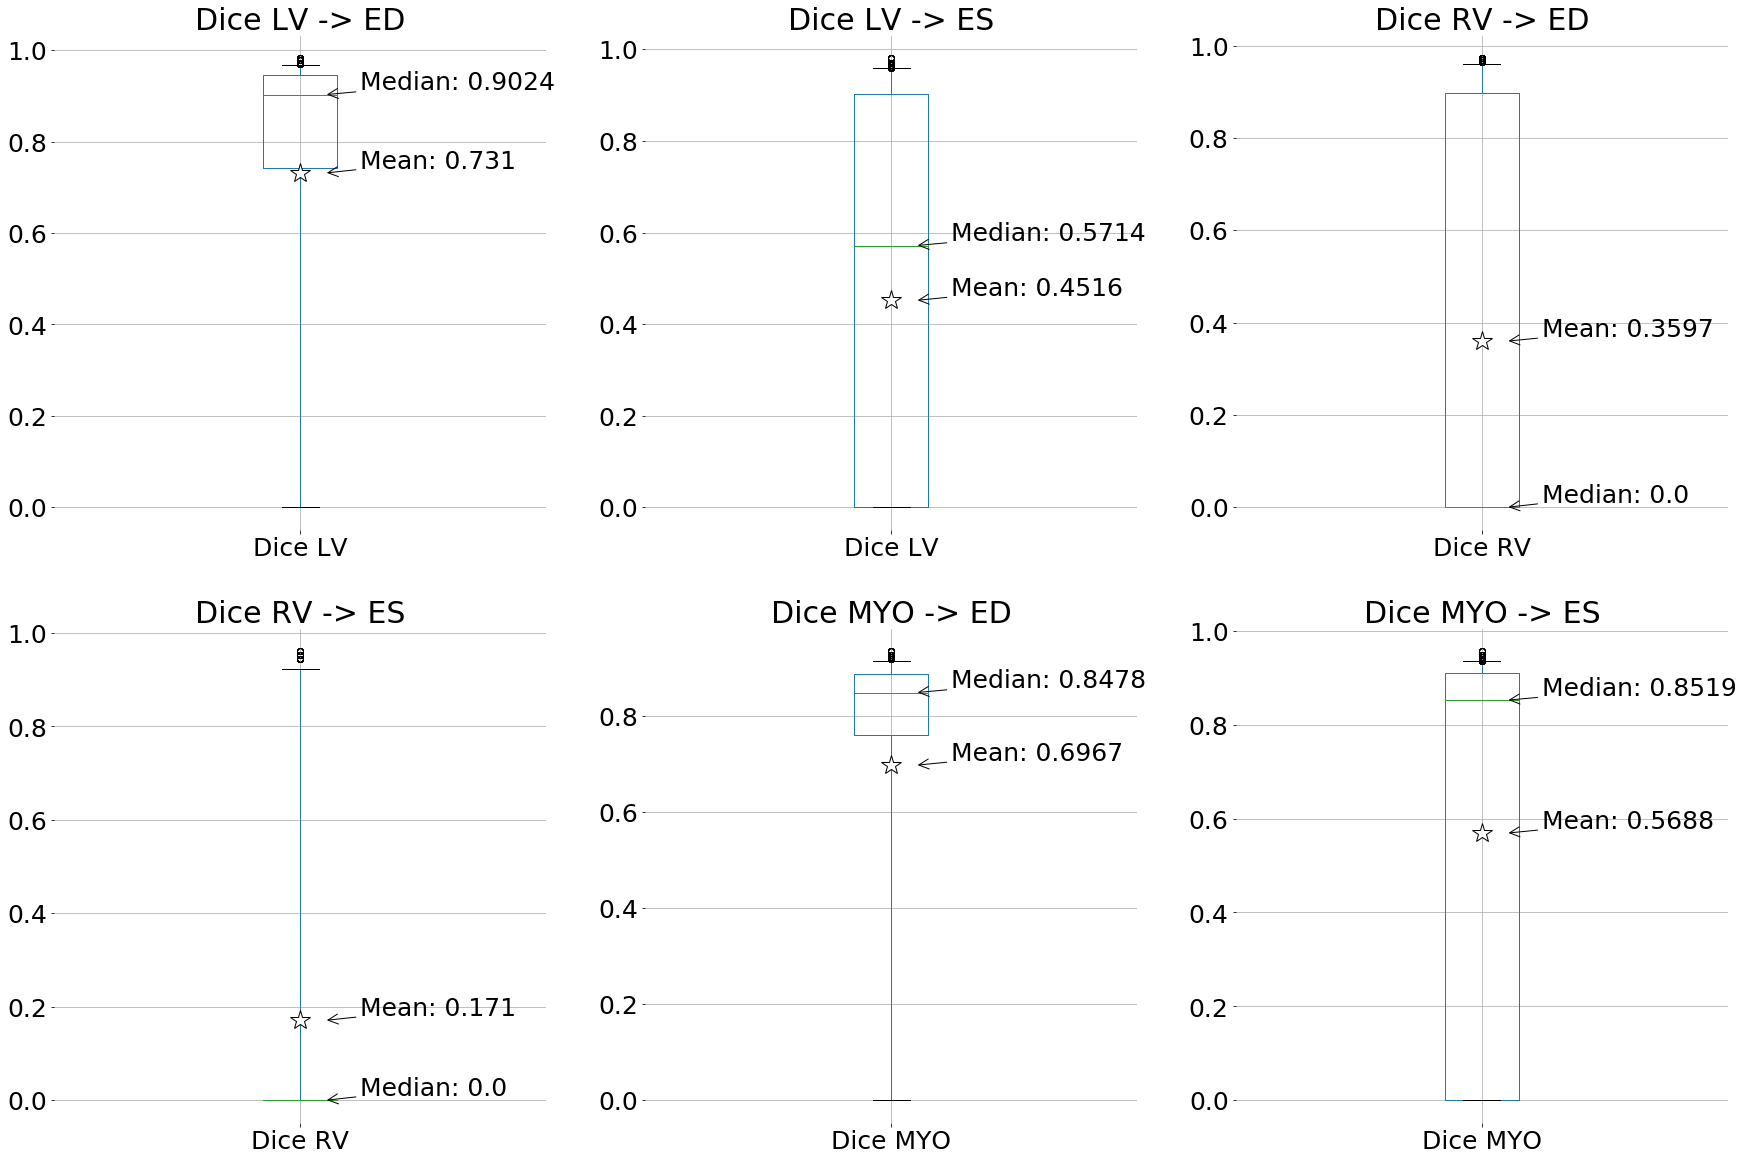

In [20]:
plot_boxplots(df)

In [176]:
df = pd.read_csv('results_OFFICAIL_8th_training_20200214_161225.csv')
df

Name   Dice LV  Volume LV  Err LV(ml)   Dice RV  Volume RV  \
0       patient1_0_ED  0.967695      0.676      -0.010  0.857143      0.107   
1       patient1_0_ES  0.927503      0.429      -0.011  0.000000      0.000   
2       patient1_1_ED  0.967695      0.676      -0.010  0.857143      0.107   
3       patient1_1_ES  0.927503      0.429      -0.011  0.000000      0.000   
4       patient1_2_ED  0.967695      0.676      -0.010  0.857143      0.107   
5       patient1_2_ES  0.927503      0.429      -0.011  0.000000      0.000   
6       patient1_3_ED  0.967695      0.676      -0.010  0.857143      0.107   
7       patient1_3_ES  0.927503      0.429      -0.011  0.000000      0.000   
8       patient1_4_ED  0.967695      0.676      -0.010  0.857143      0.107   
9       patient1_4_ES  0.927503      0.429      -0.011  0.000000      0.000   
10      patient1_5_ED  0.967695      0.676      -0.010  0.857143      0.107   
11      patient1_5_ES  0.927503      0.429      -0.011  0.000000      0.000   
12      patient1_6_ED  0.967695      0.676      -0.010  0.857143      0.107   
13      patient1_6_ES  0.927503      0.429      -0.011  0.000000      0.000   
14      patient1_7_ED  0.967695      0.676      -0.010  0.857143      0.107   
15      patient1_7_ES  0.927503      0.429      -0.011  0.000000      0.000   
16      patient1_8_ED  0.967695      0.676      -0.010  0.857143      0.107   
17      patient1_8_ES  0.927503      0.429      -0.011  0.000000      0.000   
18      patient1_9_ED  0.967695      0.676      -0.010  0.857143      0.107   
19      patient1_9_ES  0.927503      0.429      -0.011  0.000000      0.000   
20      patient2_0_ED  0.926254      0.165      -0.009  0.000000      0.000   
21      patient2_0_ES  0.931034      0.030       0.002  0.000000      0.000   
22      patient2_1_ED  0.926254      0.165      -0.009  0.000000      0.000   
23      patient2_1_ES  0.931034      0.030       0.002  0.000000      0.000   
24      patient2_2_ED  0.926254      0.165      -0.009  0.000000      0.000   
25      patient2_2_ES  0.931034      0.030       0.002  0.000000      0.000   
26      patient2_3_ED  0.926254      0.165      -0.009  0.000000      0.000   
27      patient2_3_ES  0.931034      0.030       0.002  0.000000      0.000   
28      patient2_4_ED  0.926254      0.165      -0.009  0.000000      0.000   
29      patient2_4_ES  0.931034      0.030       0.002  0.000000      0.000   
...               ...       ...        ...         ...       ...        ...   
1872   patient99_9_ED  0.857143      0.045      -0.015  0.828402      0.077   
1873   patient99_9_ES  0.000000      0.000       0.000  0.877778      0.089   
1874  patient99_10_ED  0.857143      0.045      -0.015  0.828402      0.077   
1875  patient99_10_ES  0.000000      0.000       0.000  0.877778      0.089   
1876  patient99_11_ED  0.857143      0.045      -0.015  0.828402      0.077   
1877  patient99_11_ES  0.000000      0.000       0.000  0.877778      0.089   
1878  patient99_12_ED  0.857143      0.045      -0.015  0.828402      0.077   
1879  patient99_12_ES  0.000000      0.000       0.000  0.877778      0.089   
1880  patient99_13_ED  0.857143      0.045      -0.015  0.828402      0.077   
1881  patient99_13_ES  0.000000      0.000       0.000  0.877778      0.089   
1882  patient99_14_ED  0.857143      0.045      -0.015  0.828402      0.077   
1883  patient99_14_ES  0.000000      0.000       0.000  0.877778      0.089   
1884  patient99_15_ED  0.857143      0.045      -0.015  0.828402      0.077   
1885  patient99_15_ES  0.000000      0.000       0.000  0.877778      0.089   
1886  patient100_0_ED  0.000000      0.000       0.000  0.946602      0.402   
1887  patient100_0_ES  0.000000      0.000       0.000  0.000000      0.000   
1888  patient100_1_ED  0.000000      0.000       0.000  0.946602      0.402   
1889  patient100_1_ES  0.000000      0.000       0.000  0.000000      0.000   
1890  patient100_2_ED  0.000000      0.000       0.000  0.946602   

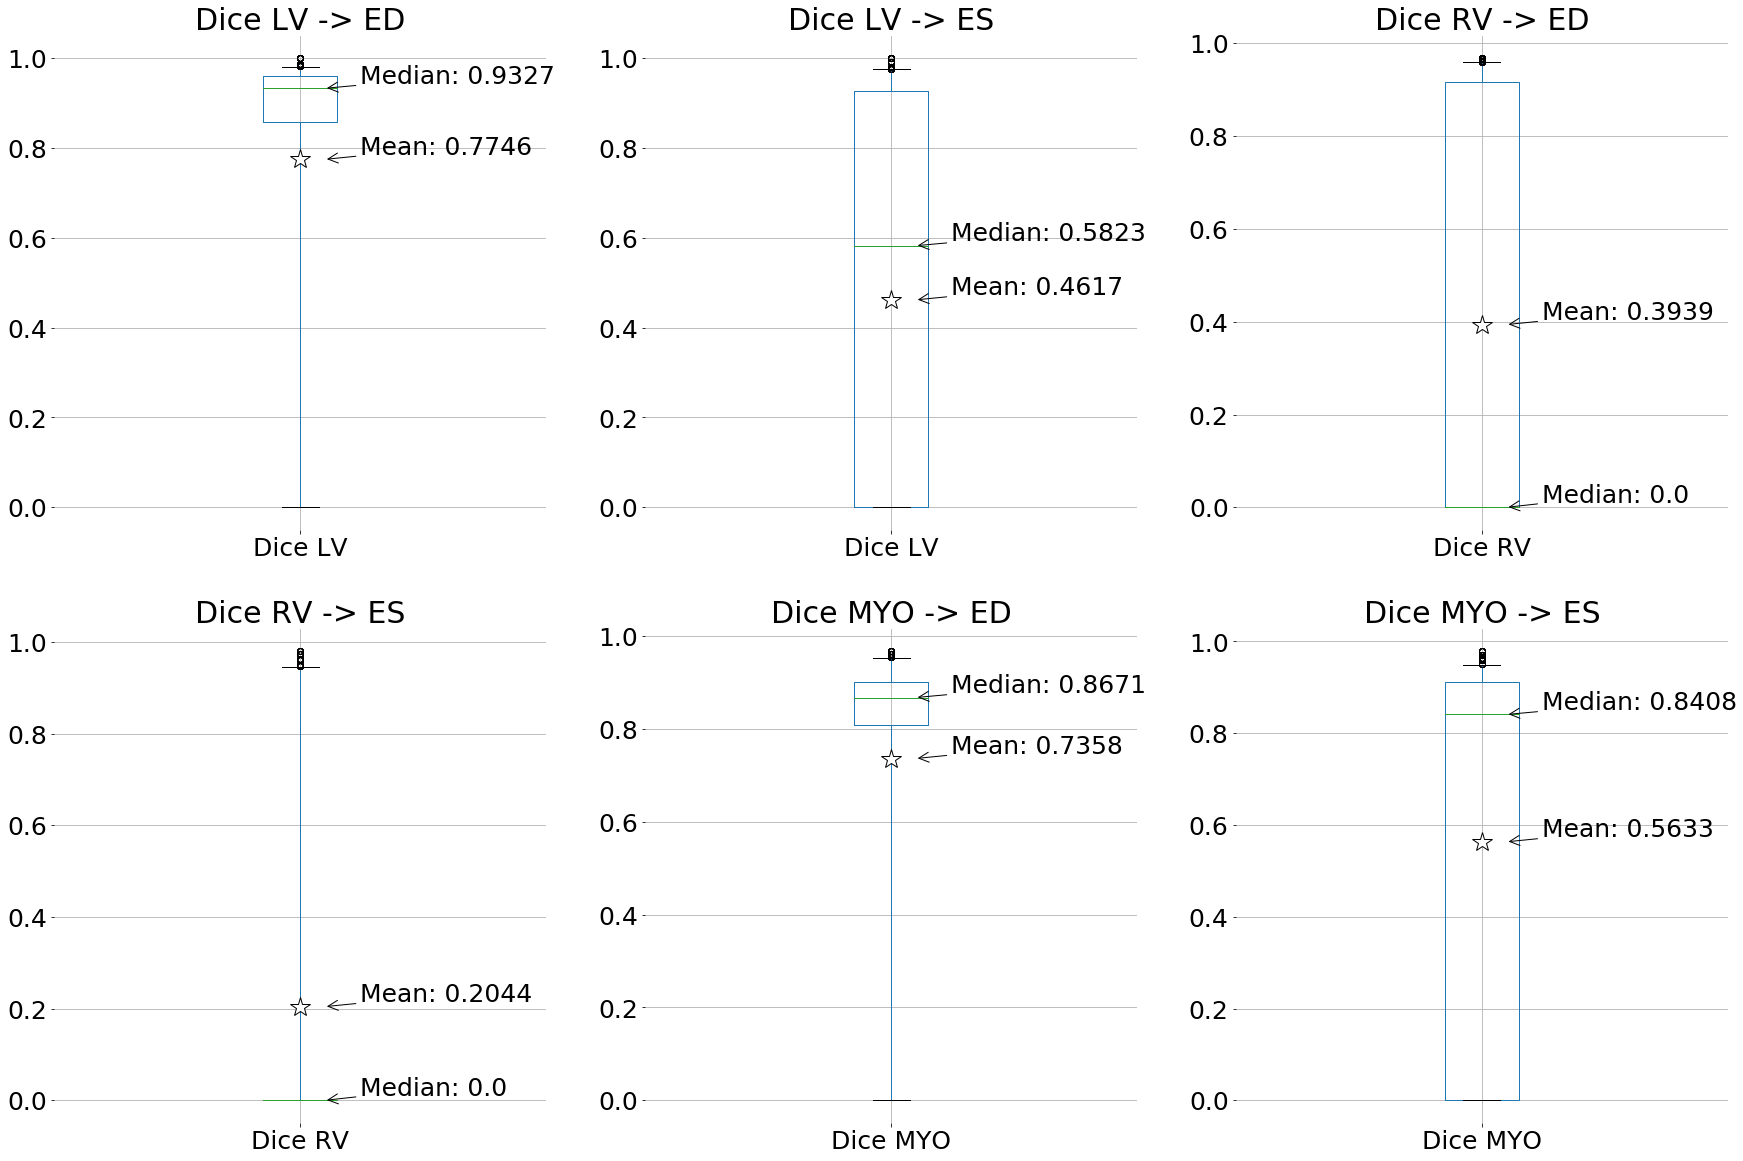

In [177]:
plot_boxplots(df)

In [23]:
LV = df[df["Name"].isin(pats["Dice LV"])]
RV = df[df["Name"].isin(pats["Dice RV"])]
MYO = df[df["Name"].isin(pats["Dice MYO"])]
ALL = df[df["Name"].isin(set([z for x in pats for z in pats[x] ]))]

lv = report_values(LV, "LV")
rv = report_values(RV, "RV")
myo = report_values(MYO, "MYO")

print("Overall DICE score for these data is: {:.4}".format(np.mean(np.concatenate((lv,rv,myo)))))

print("\nON ALL DATA (GT == 1)")
lv = report_values(ALL, "LV")
rv = report_values(ALL, "RV")      
myo = report_values(ALL, "MYO")

print("Overall DICE score for these data is: {:.4}".format(np.mean(np.concatenate((lv,rv,myo)))))

Dice LV: mean: 1.0, median: 1.0
Dice RV: mean: 1.0, median: 1.0
Dice MYO: mean: 1.0, median: 1.0
Overall DICE score for these data is: 1.0

ON ALL DATA (GT == 1)
Dice LV: mean: 0.834, median: 1.0
Dice RV: mean: 0.442, median: 0.0
Dice MYO: mean: 0.92, median: 1.0
Overall DICE score for these data is: 0.7321


### Check how many 0.0 value dice scores are in the dataset for RV

In [24]:
def zeros_collector(df):
    """Returns dictionary with the following info:
    {1: {'Dice RV': {'ed': [], 'es': [0, 1, 2, 3, 4, 5, 6, 7, 8, 9]}}, ...}
    patient id as a key and 3 metrcs with lists for each phase es and ed with ids of frames where the given score was 0.0"""
    zero_values = {}    
    for col in df.columns:
        if "Dice" in col:
            err = 0
            zero = []
            for x in df.iterrows():
                if x[1]["Name"] not in pats[col]:
                    err += x[1][col]
                    zero.append(x[1]["Name"])   
                    
            es = [x for x in zero if x.split("_")[2]=="ES"]
            ed = [x for x in zero if x.split("_")[2]=="ED"]

            for x in es:
                pat = int(x.split("_")[0].replace("patient",""))
                if not pat in zero_values:
                    zero_values[pat] = {col: {'es':[int(x.split("_")[1].replace("patient",""))], 'ed':[]}}
                elif col not in zero_values[pat]:
                    zero_values[pat][col]={'es':[int(x.split("_")[1].replace("patient",""))], 'ed':[]}                    
                else:
                    zero_values[pat][col]['es'].append(int(x.split("_")[1].replace("patient","")))
            for x in ed:
                pat = int(x.split("_")[0].replace("patient",""))
                if not pat in zero_values:
                    zero_values[pat] = {col: {'es':[], 'ed':[int(x.split("_")[1].replace("patient",""))]}}
                elif col not in zero_values[pat]:
                    zero_values[pat][col] = {'es':[], 'ed':[int(x.split("_")[1].replace("patient",""))]}                
                else:
                    zero_values[pat][col]['ed'].append(int(x.split("_")[1].replace("patient","")))
                    
    return zero_values

In [25]:
zeros =  zeros_collector(df)

In [26]:
clear = 0
lv_not_visible = 0
rv_not_visible = 0
myo_not_visible = 0
lv_not_visible_ed = 0
lv_not_visible_es = 0
rv_not_visible_ed = 0
rv_not_visible_es = 0
myo_not_visible_ed = 0
myo_not_visible_es = 0

for i in range(1,101):
    if i not in zeros:
        clear += 1
    else:
        if "Dice RV" in zeros[i]:
            if zeros[i]["Dice RV"]["es"] != [] and zeros[i]["Dice RV"]["ed"] != []:
                rv_not_visible += 1
            elif zeros[i]["Dice RV"]["es"] != []:
                rv_not_visible_es +=1
            elif zeros[i]["Dice RV"]["ed"] != []:
                rv_not_visible_ed +=1
        if "Dice LV" in zeros[i]:
            if zeros[i]["Dice LV"]["es"] != [] and zeros[i]["Dice LV"]["ed"] != []:
                lv_not_visible += 1
            elif zeros[i]["Dice LV"]["es"] != []:
                lv_not_visible_es += 1
            elif zeros[i]["Dice LV"]["ed"] != []:
                lv_not_visible_ed += 1
        if "Dice MYO" in zeros[i]:
            if zeros[i]["Dice MYO"]["es"] != [] and zeros[i]["Dice MYO"]["ed"] != []:
                myo_not_visible += 1
            elif zeros[i]["Dice MYO"]["es"] != []:
                myo_not_visible_es += 1
            elif zeros[i]["Dice MYO"]["ed"] != []:
                myo_not_visible_ed += 1

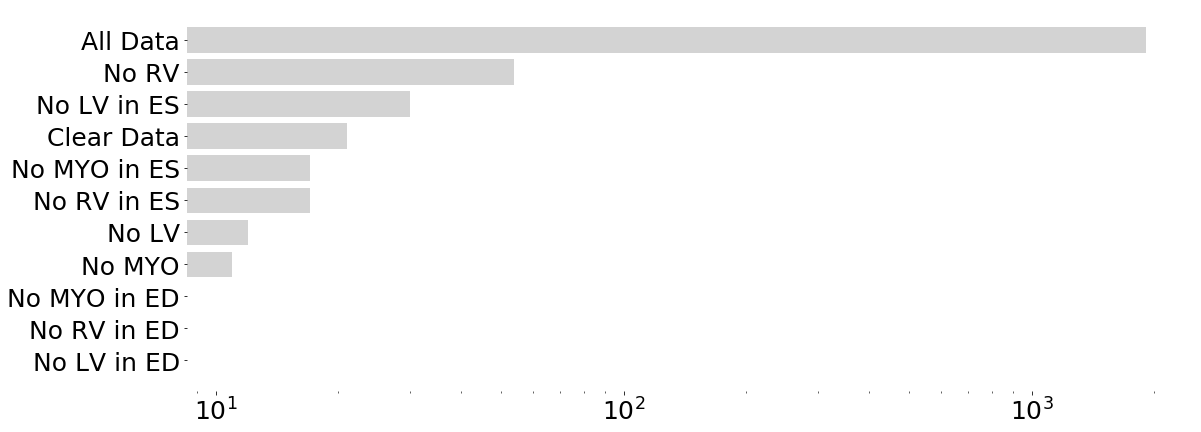

In [27]:
plt.figure(figsize=(18,7))
all_ = len(df)
vals = [all_, clear,lv_not_visible,rv_not_visible,myo_not_visible,lv_not_visible_ed,lv_not_visible_es,rv_not_visible_ed,rv_not_visible_es,myo_not_visible_ed,myo_not_visible_es]
labels = ["All Data","Clear Data", "No LV","No RV","No MYO", "No LV in ED", "No LV in ES", "No RV in ED","No RV in ES","No MYO in ED","No MYO in ES"]
ids = np.argsort(vals)
labels = [labels[i] for i in ids]
vals = [vals[i] for i in ids]
plt.barh(labels,vals, color="#D3D3D3")
plt.xscale('log')
plt.box("off")
plt.show()

In [28]:
zeros

{1: {'Dice RV': {'ed': [], 'es': [0, 1, 2, 3, 4, 5, 6, 7, 8, 9]}},
 2: {'Dice RV': {'ed': [0, 1, 2, 3, 4, 5, 6, 7, 8, 9],
   'es': [0, 1, 2, 3, 4, 5, 6, 7, 8, 9]}},
 3: {'Dice RV': {'ed': [0, 1, 2, 3, 4, 5, 6, 7, 8, 9],
   'es': [0, 1, 2, 3, 4, 5, 6, 7, 8, 9]}},
 4: {'Dice RV': {'ed': [0, 1, 2, 3, 4, 5, 6, 7, 8, 9],
   'es': [0, 1, 2, 3, 4, 5, 6, 7, 8, 9]}},
 5: {'Dice RV': {'ed': [], 'es': [0, 1, 2, 3, 4, 5, 6, 7, 8, 9]}},
 6: {'Dice RV': {'ed': [], 'es': [0, 1, 2, 3, 4, 5, 6, 7, 8, 9, 10]}},
 8: {'Dice RV': {'ed': [0, 1, 2, 3, 4, 5, 6, 7, 8, 9],
   'es': [0, 1, 2, 3, 4, 5, 6, 7, 8, 9]}},
 9: {'Dice RV': {'ed': [0, 1, 2, 3, 4, 5, 6, 7, 8, 9],
   'es': [0, 1, 2, 3, 4, 5, 6, 7, 8, 9]}},
 10: {'Dice RV': {'ed': [], 'es': [0, 1, 2, 3, 4, 5, 6, 7, 8, 9]}},
 12: {'Dice RV': {'ed': [0, 1, 2, 3, 4, 5, 6, 7, 8, 9],
   'es': [0, 1, 2, 3, 4, 5, 6, 7, 8, 9]}},
 13: {'Dice RV': {'ed': [0, 1, 2, 3, 4, 5, 6, 7, 8, 9],
   'es': [0, 1, 2, 3, 4, 5, 6, 7, 8, 9]}},
 14: {'Dice RV': {'ed': [0, 1, 2, 3, 4,

In [41]:
ed_rv_zero = sum([len(zeros[x]['Dice RV']['ed']) for x in zeros if 'Dice RV' in zeros[x] and 'ed' in zeros[x]['Dice RV']])
es_rv_zero = sum([len(zeros[x]['Dice RV']['es']) for x in zeros if 'Dice RV' in zeros[x] and 'es' in zeros[x]['Dice RV']])
ed_lv_zero = sum([len(zeros[x]['Dice LV']['ed']) for x in zeros if 'Dice LV' in zeros[x] and 'ed' in zeros[x]['Dice LV']])
es_lv_zero = sum([len(zeros[x]['Dice LV']['es']) for x in zeros if 'Dice LV' in zeros[x] and 'es' in zeros[x]['Dice LV']])
ed_myo_zero = sum([len(zeros[x]['Dice MYO']['ed']) for x in zeros if 'Dice MYO' in zeros[x] and 'ed' in zeros[x]['Dice MYO']])
es_myo_zero = sum([len(zeros[x]['Dice MYO']['es']) for x in zeros if 'Dice MYO' in zeros[x] and 'es' in zeros[x]['Dice MYO']])

In [42]:
ed_rv_zero, es_rv_zero, ed_lv_zero, es_lv_zero, ed_myo_zero, es_myo_zero

(504, 675, 120, 419, 110, 287)

In [151]:
heatmap = np.zeros((2,3))
phases = ['ed','es']
scores = ['Dice RV', 'Dice LV', 'Dice MYO']
#names = [s.split(' ')[1] for s in scores]
for i, phase in enumerate(phases):
    for j, score in enumerate(scores):
        heatmap[i,j] = sum([len(zeros[x][score][phase]) for x in zeros if score in zeros[x] and phase in zeros[x][score]])

In [129]:
heatmap_full = np.zeros((2,7))
ind = 3
heatmap_full[:,:ind] = heatmap
for i, phase in enumerate(phases):
    heatmap_full[i,ind] = #sum([len(zeros[x][score][phase]) for x in zeros if score in zeros[x] and phase in zeros[x][score]])
    ind += 1

In [208]:
patients = np.zeros((100, 6))
for i in range(1,101):
    print("Patient ",i)
    if i in zeros:
                     
        if 'Dice MYO' in zeros[i]:
            tmp = zeros[i]['Dice MYO']['ed']
            print("MYO ed: ",tmp)           
            patients[i,0] = len(tmp)            
            tmp = zeros[i]['Dice MYO']['es']
            print("MYO es: ", tmp)  
            patients[i,1] = len(tmp)            
            
        if 'Dice LV' in zeros[i]:
            tmp = zeros[i]['Dice LV']['ed']
            print("LV ed: ",tmp)
            patients[i,2] = len(tmp)
            tmp = zeros[i]['Dice LV']['es']
            print("LV es: ",tmp)    
            patients[i,3] = len(tmp)                         

        if 'Dice RV' in zeros[i]:
            tmp = zeros[i]['Dice RV']['ed']
            print("RV ed: ",tmp) 
            patients[i,4] = len(tmp)            
            tmp = zeros[i]['Dice RV']['es']
            print("RV es: ", tmp)     
            patients[i,5] = len(tmp)                        
            
    else:
        print("No missing structures")
    

Patient  1
RV ed:  []
RV es:  [0, 1, 2, 3, 4, 5, 6, 7, 8, 9]
Patient  2
RV ed:  [0, 1, 2, 3, 4, 5, 6, 7, 8, 9]
RV es:  [0, 1, 2, 3, 4, 5, 6, 7, 8, 9]
Patient  3
RV ed:  [0, 1, 2, 3, 4, 5, 6, 7, 8, 9]
RV es:  [0, 1, 2, 3, 4, 5, 6, 7, 8, 9]
Patient  4
RV ed:  [0, 1, 2, 3, 4, 5, 6, 7, 8, 9]
RV es:  [0, 1, 2, 3, 4, 5, 6, 7, 8, 9]
Patient  5
RV ed:  []
RV es:  [0, 1, 2, 3, 4, 5, 6, 7, 8, 9]
Patient  6
RV ed:  []
RV es:  [0, 1, 2, 3, 4, 5, 6, 7, 8, 9, 10]
Patient  7
No missing structures
Patient  8
RV ed:  [0, 1, 2, 3, 4, 5, 6, 7, 8, 9]
RV es:  [0, 1, 2, 3, 4, 5, 6, 7, 8, 9]
Patient  9
RV ed:  [0, 1, 2, 3, 4, 5, 6, 7, 8, 9]
RV es:  [0, 1, 2, 3, 4, 5, 6, 7, 8, 9]
Patient  10
RV ed:  []
RV es:  [0, 1, 2, 3, 4, 5, 6, 7, 8, 9]
Patient  11
No missing structures
Patient  12
RV ed:  [0, 1, 2, 3, 4, 5, 6, 7, 8, 9]
RV es:  [0, 1, 2, 3, 4, 5, 6, 7, 8, 9]
Patient  13
RV ed:  [0, 1, 2, 3, 4, 5, 6, 7, 8, 9]
RV es:  [0, 1, 2, 3, 4, 5, 6, 7, 8, 9]
Patient  14
RV ed:  [0, 1, 2, 3, 4, 5, 6, 7, 8, 9]
RV es:  

IndexError: index 100 is out of bounds for axis 0 with size 100

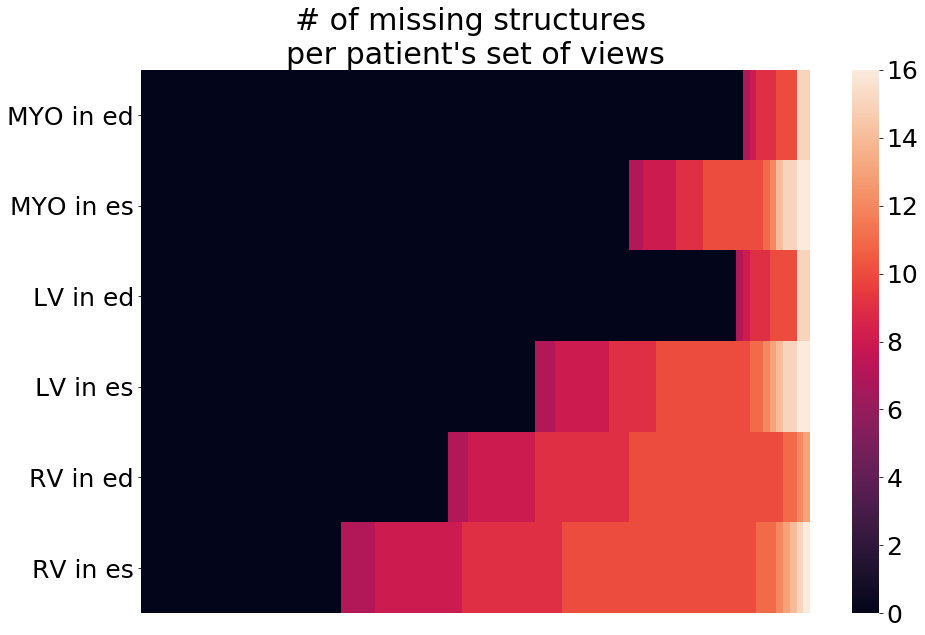

In [215]:
plt.figure(figsize=(15,10))
sns.heatmap(np.sort(patients, axis=0).transpose(), xticklabels=False, yticklabels=["MYO in ed","MYO in es","LV in ed","LV in es", "RV in ed","RV in es"])
plt.title("# of missing structures \nper patient's set of views")
plt.show()

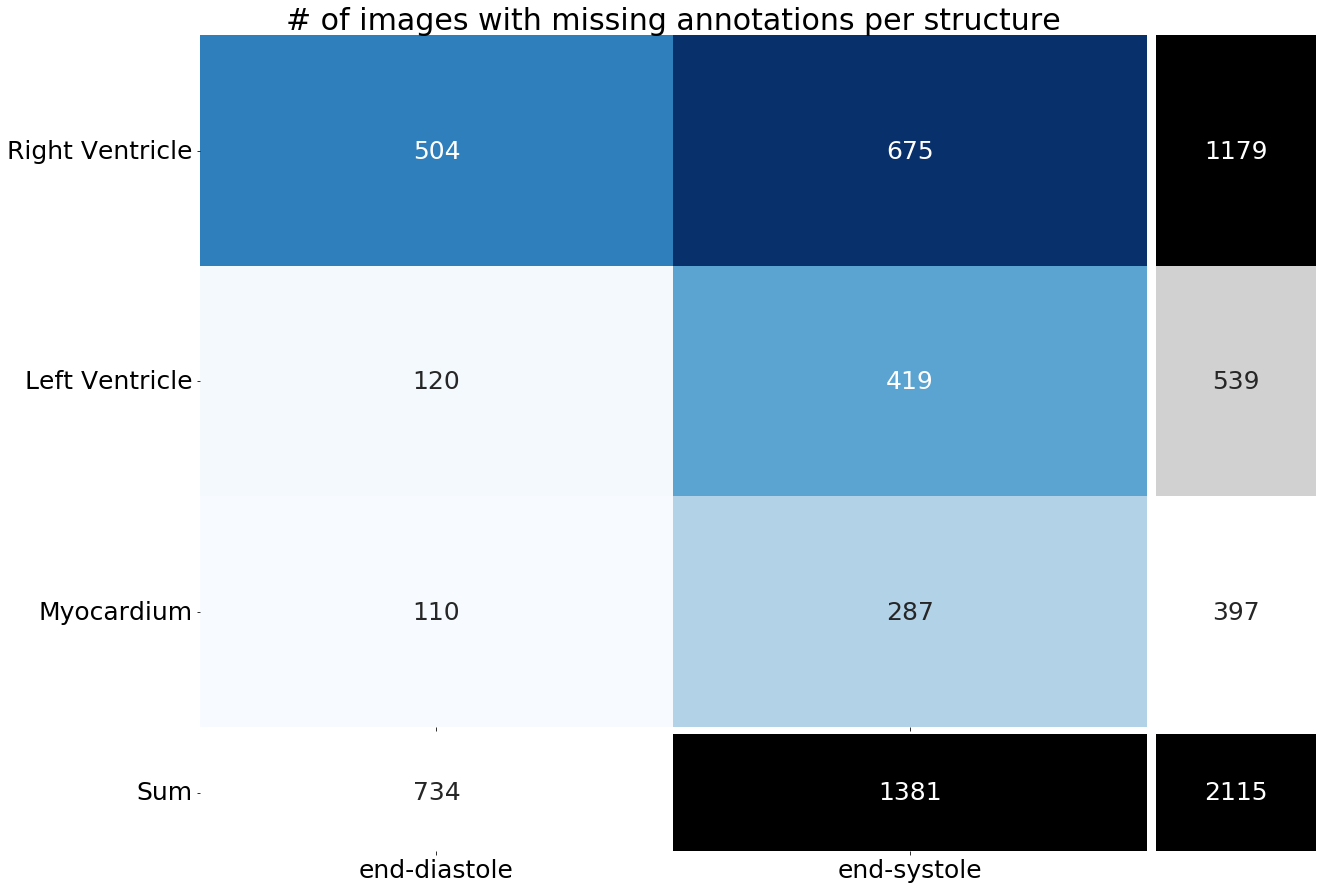

In [216]:
import seaborn as sns
#heatmap = heatmap_full
fig = plt.figure(figsize=(20,15))
ax1 = plt.subplot2grid((20,20), (0,0), colspan=17, rowspan=17)
ax2 = plt.subplot2grid((20,20), (17,0), colspan=17, rowspan=3)
ax3 = plt.subplot2grid((20,20), (0,17), colspan=3, rowspan=17)
ax4 = plt.subplot2grid((20,20), (17,17), colspan=3, rowspan=3)
names_cls = ["Right Ventricle", "Left Ventricle", "Myocardium" ]
#names_cls = ['RV','LV','RV LV','MYO','RV LV MYO']
names_phase = ['end-diastole', 'end-systole']
sns.heatmap(heatmap.astype(int).transpose(), ax=ax1,cbar=False, xticklabels=names_phase, yticklabels=names_cls,cmap="Blues", annot=True, fmt="d")
sns.heatmap((heatmap.sum(axis=0)).reshape(-1,1).astype(int), ax=ax3, annot=True, fmt="d", cmap="binary", cbar=False, xticklabels=False, yticklabels=False)
sns.heatmap(heatmap.sum(axis=1).transpose().reshape(1,-1).astype(int), ax=ax2, annot=True, fmt="d", cmap="binary", cbar=False, xticklabels=names_phase, yticklabels=["sum"])
sns.heatmap(np.array([int(sum(heatmap.sum(axis=1)))]).reshape(-1,1), ax=ax4, annot=True, fmt="d", cmap="gray", cbar=False, xticklabels=False, yticklabels=False)

ax1.set_yticklabels(names_cls, 
    rotation=0, va="center")
ax2.set_yticklabels(["Sum"], 
    rotation=0, va="center")
ax1.set_title("# of images with missing annotations per structure")
plt.show()

In [221]:
set(df["Dice LV"].values)
set(df["Dice MYO"].values)

{0.0, 1.0}

In [508]:
from sklearn.decomposition import PCA
from sklearn.cluster import KMeans

def cluster_images(df):
    size = len(df)
    ids = []
    patients = np.zeros((size, 4))
    for i, pat in enumerate(df.iterrows()):
        ids.append(pat[1]["Name"])
        patients[i,0] = pat[1]["Dice LV"]
        patients[i,1] = pat[1]["Dice RV"]
        patients[i,2] = pat[1]["Dice MYO"]
        patients[i,3] = 1 if pat[1]["Types"] == "ED" else 0

    pcs = PCA().fit_transform(patients)

    plt.figure(figsize=(18,10))
    plt.scatter(pcs[:,0],pcs[:,1], marker='x')
    plt.show()

    kmeans = KMeans(n_clusters=11)
    clusters = kmeans.fit_predict(pcs)

    #print('l___r___m_|_D/S')
    for cls in range(11):
        #print("   ".join(patients[clusters.tolist().index(cls)].astype(int).astype(str).tolist()))
        pass
    clses = []
    for cls in range(11):   
        tmp = patients[clusters.tolist().index(cls),:3].astype(int).astype(str).tolist()
        clses.append(" ".join(tmp))
        #print("   ".join(tmp))
    clses = set(clses)
    return clses, patients

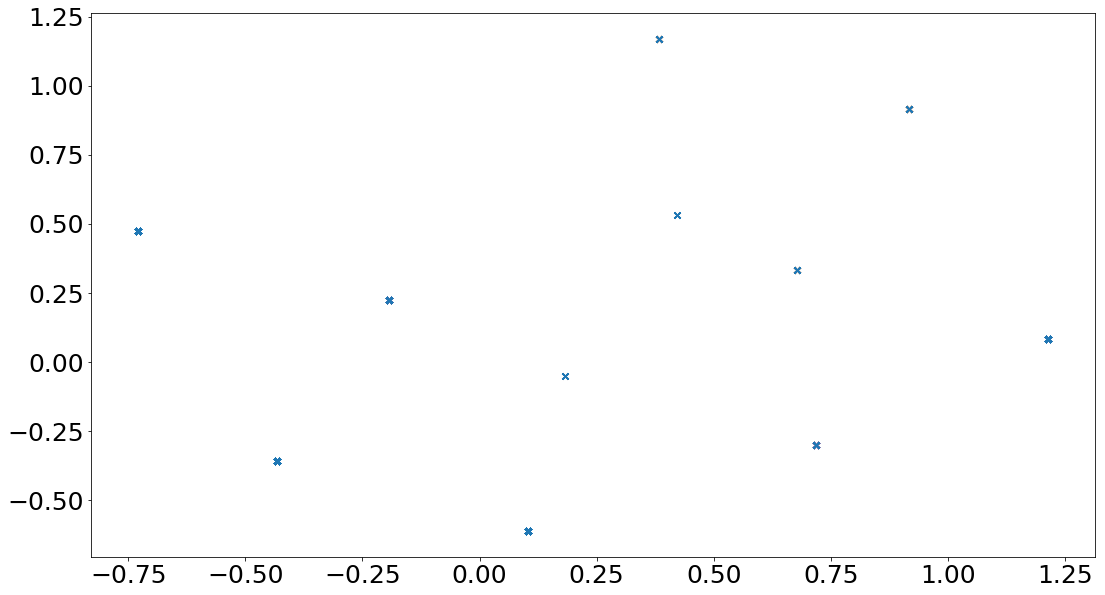

In [509]:
clses, patients = cluster_images(df)

In [510]:
clses

{'0 0 0', '0 0 1', '0 1 0', '0 1 1', '1 0 1', '1 1 1'}

In [514]:
def get_counts(patients, all_, diastole=0):
    counts = []
    inds = (0,1,2)
    #systole
    #inds = (3,4,5)
    for c in set(clses):
        code = [int(x) for x in c.split(' ')] 
        if all_:
            cond = (patients[:,inds[0]] == code[0])&(patients[:,inds[1]] == code[1]) & (patients[:,inds[2]] == code[2])        
        else:
            cond = (patients[:,inds[0]] == code[0])&(patients[:,inds[1]] == code[1]) & (patients[:,inds[2]] == code[2]) & (patients[:,3] == diastole)
        count = len(patients[cond])
        #print(c, count)
        counts.append(count)
    return counts

In [549]:
all_ = 0
diastole = 0
counts = get_counts(patients, all_, diastole)

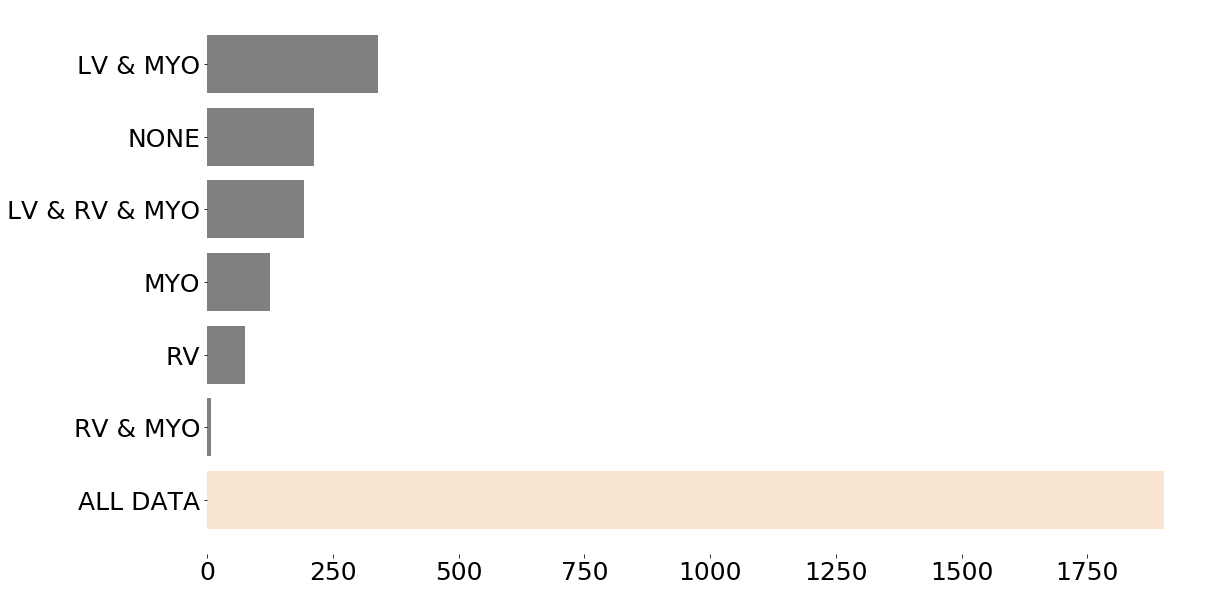

In [550]:
plt.figure(figsize=(18,10))
clases = ["LV & RV & MYO","RV & MYO","NONE","RV","LV & MYO","MYO"]
plt.barh("ALL DATA",len(df),color='#fae5d3')
plt.barh([clases[i] for i in np.argsort(counts)],np.sort(counts), color='gray')
plt.box("off")
plt.show()

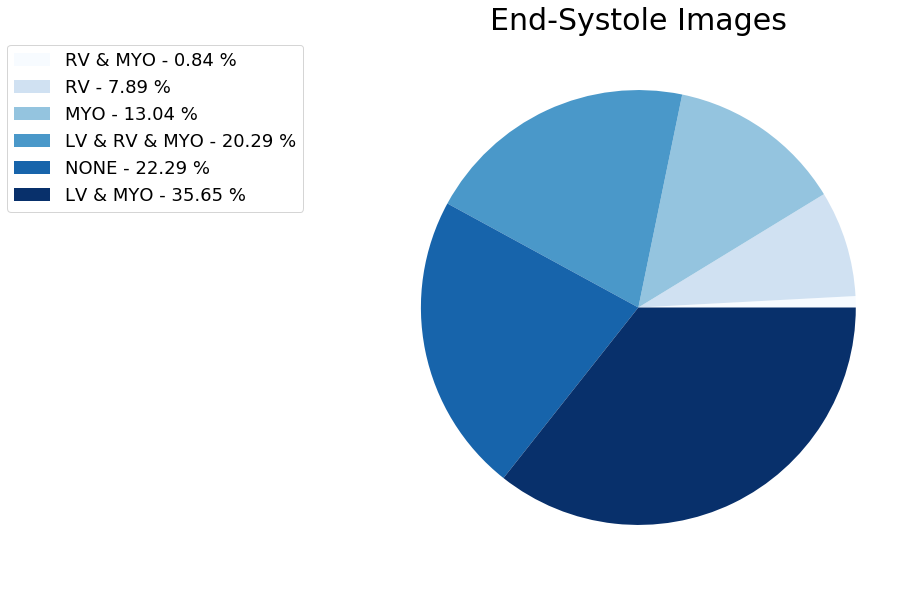

In [551]:
porcent = 100.*np.sort(counts)/np.sort(counts).sum()



theme = plt.get_cmap("Blues",lut=6)
plt.figure(figsize=(18,10))
patches, texts = plt.pie(np.sort(counts), colors=[theme(i) for i in range(len(counts))])
labels = ['{0} - {1:1.2f} %'.format(i,j) for i,j in zip([clases[i] for i in np.argsort(counts)], porcent)]

plt.legend(patches, labels, loc='left center', bbox_to_anchor=(-0.1, 1.),
           fontsize=18)
if diastole:
    plt.title("End-Diastole Images")
else:
    plt.title("End-Systole Images")
if all_:
    plt.title("All Images")
plt.show()

In [552]:
x = get_counts(patients,0,1)
y = get_counts(patients,0,0)
full = []
for i,j in zip(x,y):
    full.append(i)
    full.append(j)

In [536]:
full

[392, 193, 0, 8, 55, 212, 55, 75, 439, 339, 10, 124]

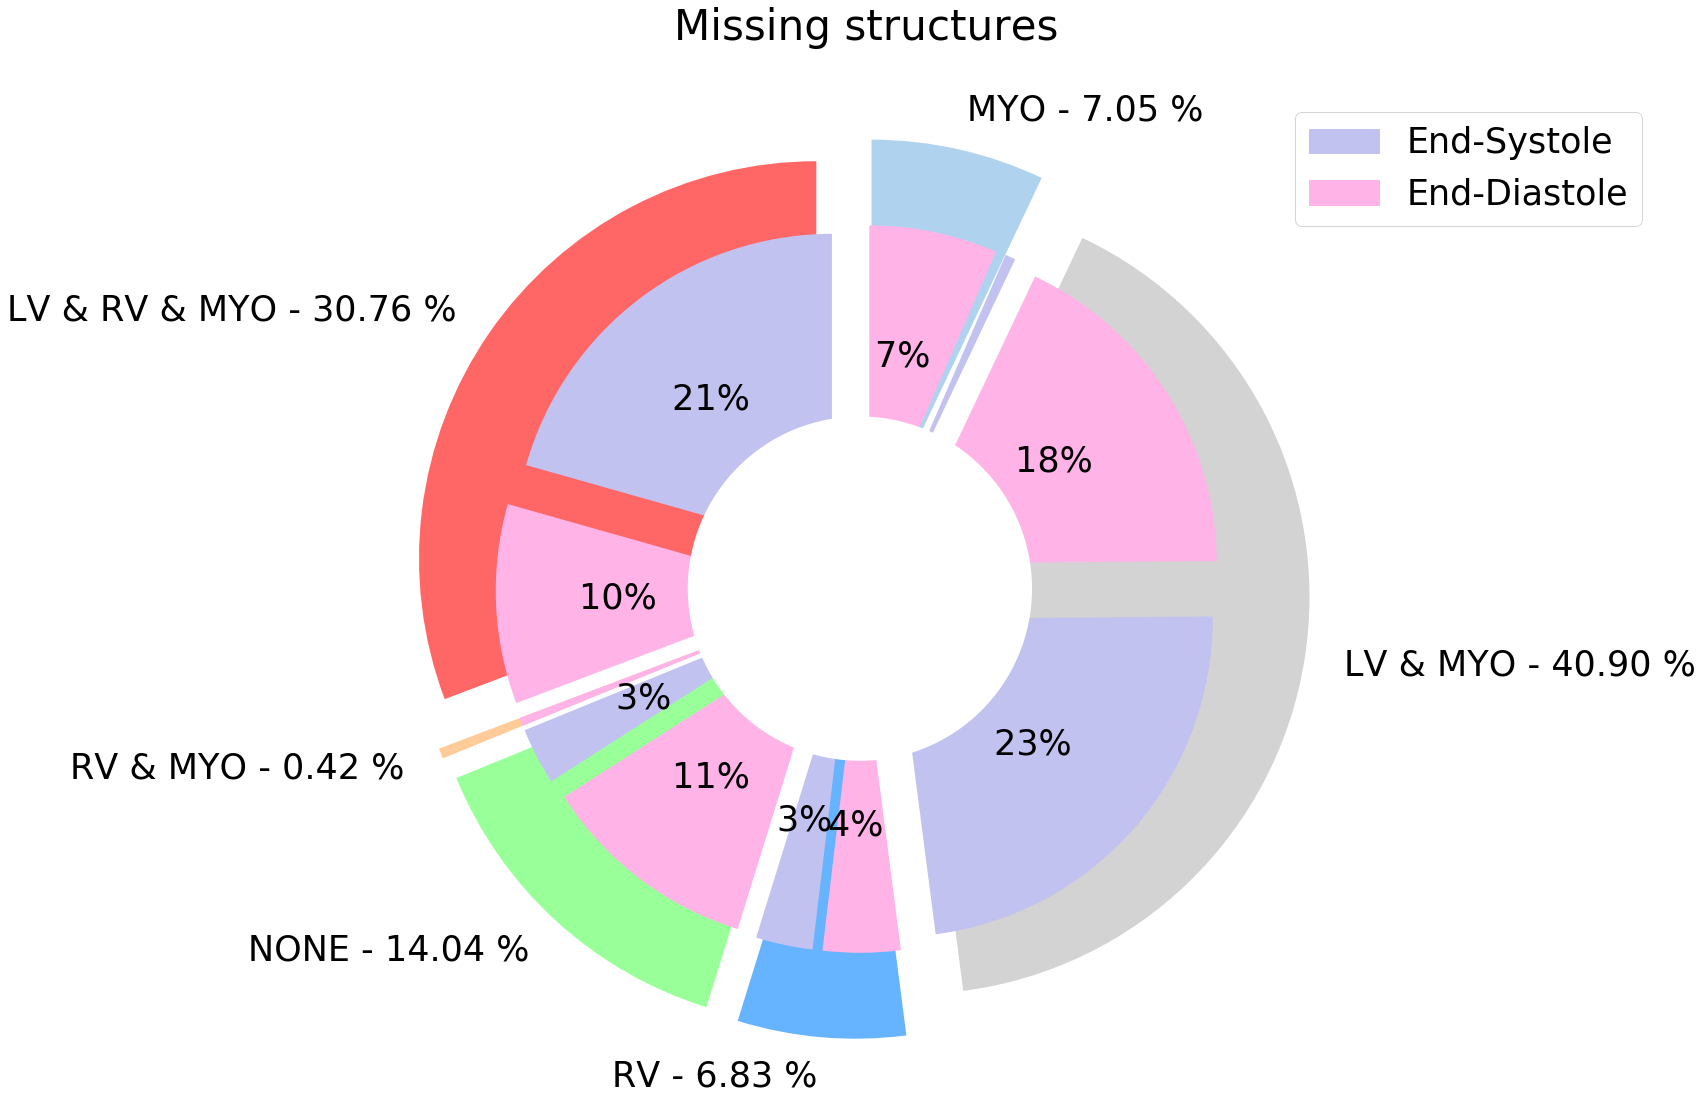

In [561]:
import matplotlib.pyplot as plt
import matplotlib.patches as mpatches
plt.rcParams.update({'font.size': 35})
# Data to plot
sizes = get_counts(patients,1) #[504, 337, 415, 280,100,160]
porcent = 100.*np.array(sizes)/np.array(sizes).sum()
labels = ["LV & RV & MYO","RV & MYO","NONE","RV","LV & MYO","MYO"]
labels = ['{0} - {1:1.2f} %'.format(i,j) for i,j in zip([labels[i] for i in range(len(counts))], porcent)]

labels_gender = ['ED','ES']*len(labels)
sizes_gender = full #[315,189,125,212,270,145,190,90,50,50,100,60]
colors = ['#ff6666', '#ffcc99', '#99ff99', '#66b3ff','#d3d3d3','#afd3ef']
colors_gender = ['#c2c2f0','#ffb3e6']*len(labels)#, '#c2c2f0','#ffb3e6', '#c2c2f0','#ffb3e6', '#c2c2f0','#ffb3e6','#c2c2f0','#ffb3e6','#c2c2f0','#ffb3e6']
explode = [0.4]*len(labels) 
explode_gender = [0.35]*len(labels_gender)
plt.figure(figsize=(25,15))
plt.pie(sizes, labels=labels, colors=colors, startangle=90,frame=True, explode=explode,radius=3)
_,_,autotexts = plt.pie(sizes_gender,colors=colors_gender,startangle=90, explode=explode_gender,autopct=lambda p: '{:.0f}% '.format(round(p)) if p > 0.9 else '',radius=2.4)#Draw circle
centre_circle = plt.Circle((0,0),1.3,color='black', fc='white',linewidth=0)
#plt.legend()
fig = plt.gcf()
fig.gca().add_artist(centre_circle)
 
plt.axis('equal')
plt.tight_layout()
#plt.setp(autotexts, size=8, weight="bold")
plt.title("Missing structures\n")
red_patch = mpatches.Patch(color=colors_gender[0], label='End-Systole')
blue_patch = mpatches.Patch(color=colors_gender[1], label='End-Diastole')

plt.legend(handles=[red_patch, blue_patch])
plt.show()

### 11th training

major changes:
- more batches in one epoch - 2000
- transformations
- batch size 10
- 48 filters
- epochs 175

In [399]:
df = pd.read_csv('results_OFFICIAL_11th_20200217_235044.csv')
calculate_results('results_OFFICIAL_11th_20200217_235044.csv',loss=False)

Dice LV  => ED: 63.87 %, ES:  63.87%
Dice RV  => ED: 31.11 %, ES:  31.11%
Dice MYO => ED: 67.93 %, ES:  67.93%
Dice LV: mean: 0.628, median: 0.924
Dice RV: mean: 0.323, median: 0.0
Dice MYO: mean: 0.668, median: 0.887
Overall dice: mean: 0.54, median: 0.868


In [489]:
def display_score_per_task(df, pats):
    LV = df[df["Name"].isin(pats["Dice LV"])]
    RV = df[df["Name"].isin(pats["Dice RV"])]
    MYO = df[df["Name"].isin(pats["Dice MYO"])]
    ALL = df[df["Name"].isin(set([z for x in pats for z in pats[x] ]))]

    lv = report_values(LV, "LV")
    rv = report_values(RV, "RV")
    myo = report_values(MYO, "MYO")

    print("Overall DICE score for these data is: {:.4}".format(np.mean(np.concatenate((lv,rv,myo)))))

    print("\nON ALL DATA (GT == 1)")
    lv = report_values(ALL, "LV")
    rv = report_values(ALL, "RV")      
    myo = report_values(ALL, "MYO")

    print("Overall DICE score for these data is: {:.4}".format(np.mean(np.concatenate((lv,rv,myo)))))

In [490]:
display_score_per_task(df, pats)

Dice LV: mean: 1.0, median: 1.0
Dice RV: mean: 1.0, median: 1.0
Dice MYO: mean: 1.0, median: 1.0
Overall DICE score for these data is: 1.0

ON ALL DATA (GT == 1)
Dice LV: mean: 0.834, median: 1.0
Dice RV: mean: 0.442, median: 0.0
Dice MYO: mean: 0.92, median: 1.0
Overall DICE score for these data is: 0.7321
